# M2177.003100 Deep Learning <br> Assignment #4 Implementing Generative Adversarial Nets - part2 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Chaehun Shin, September 2020

In this notebook, you will learn how to implement Generative Adversarial Networks (GANs) <br>
The goal here is to build GANs that draw hand-written digits (MNIST data) <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Student_ID** as input argument. <br>
This will produce a zipped file called *[Your Student_ID].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Student_ID)

### Some helpful tutorials and references for assignment #4-2:
- [1] Pytorch official tutorials. [[link]](https://pytorch.org/tutorials/)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data/mnist' directory. If you want to change the directory the data is saved in, change 'mnist_data_dir' with where you want. <br>

In [1]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as T

mnist_data_dir = './data/mnist'
dataset = MNIST(root=mnist_data_dir,
               transform=T.ToTensor(), train=True, download=True)
print(dataset.train_data.shape)
print(dataset.train_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


/home/ccw/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/ccw/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## <a name="1"></a> 1. Building a network


In this section, you will implement neural networks for <br>
(1) generator model to draw a digit <br>
(2) discriminator model to distinguish real images from generated images.<br>
You can use some layer function implemented in **'torch.nn'** library (abbretivated as **nn**) or **'torch.nn.functional'** library (abbreviated as **F**) as you want.
Just write the code in whatever way you find most clear.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

It is time for a generator model.
You can change anything including the argument if you need. Feel Free to implement it.<br>
**(You should output the image as a range (0, 1) with Sigmoid function because we normalize the real images as a range (0, 1))**

In [41]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, image_dim=1):
        super().__init__()
        ################ ToDo ################
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    def forward(self, z):
        ################ ToDo ################
        z = z.view(x.size(0), 100)
        out = self.model(x)
        return out
        

Now, it's time for a discriminator model. Again, you can implement anything if you need. <br>
**(You should output the probability of whether the input image of discriminator is real or not. It means that you use the Sigmoid function at the last layer to make the value being in range (0, 1))**

In [40]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=3):
        super().__init__()
        ################ ToDo ################
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        ################ ToDo ################
        out = self.model(img.view(img.size(0), 784))
        out = out.view(out.size(0), -1)
        return out
    

## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part (define criterion variable and D_loss/G_loss to train in TODO parts, you can also use the criterion variable).
Feel free to set the hyperparmeters and fill in the main part.
When you are done, run the following to check your implementations.
In this section, you will implement the main part (define criterion variable and D_loss/G_loss to train in TODO parts).

You must show **at least three generated images** (At the beginning of, in the midway of, at the end of training).

In [42]:
# hyperparameter setting
# img_dim=1
img_dim = 784
img_size = 28
latent_dim = 100
num_D_updates_per_G_update = 5

batch_size = 128
learning_rate = 1e-4
total_iter = 50000

log_freq = 10
viz_freq = 200

gen_num_samples = 50

hdim1 = 256
hdim2 = 128

/home/ccw/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Iter: 00010/50000, Gen loss: 0.0060, Dis loss: 7.7006
Iter: 00020/50000, Gen loss: 0.0009, Dis loss: 9.5166
Iter: 00030/50000, Gen loss: 0.0005, Dis loss: 9.6595
Iter: 00040/50000, Gen loss: 0.0004, Dis loss: 10.0194
Iter: 00050/50000, Gen loss: 0.0004, Dis loss: 10.1196
Iter: 00060/50000, Gen loss: 0.0005, Dis loss: 10.8477
Iter: 00070/50000, Gen loss: 0.0006, Dis loss: 11.5455
Iter: 00080/50000, Gen loss: 0.0010, Dis loss: 13.0397
Iter: 00090/50000, Gen loss: 0.0002, Dis loss: 13.8015
Iter: 00100/50000, Gen loss: 0.0005, Dis loss: 15.8293
Iter: 00110/50000, Gen loss: 0.0008, Dis loss: 18.9794
Iter: 00120/50000, Gen loss: 0.0015, Dis loss: 23.1162
Iter: 00130/50000, Gen loss: 0.0004, Dis loss: 18.6229
Iter: 00140/50000, Gen loss: 0.0008, Dis loss: 19.1324
Iter: 00150/50000, Gen loss: 0.0114, Dis loss: 18.2568
Iter: 00160/50000, Gen loss: 0.0004, Dis loss: 15.2584
Iter: 00170/50000, Gen loss: 0.0018, Dis loss: 14.7261
Iter: 00180/50000, Gen loss: 0.0086, Dis loss: 15.4122
Iter: 00190/5

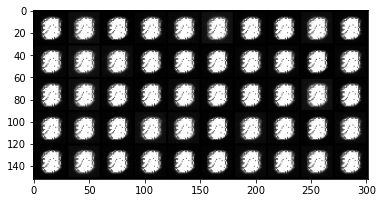

Iter: 00210/50000, Gen loss: 0.0024, Dis loss: 12.6532
Iter: 00220/50000, Gen loss: 0.0002, Dis loss: 11.2841
Iter: 00230/50000, Gen loss: 0.0004, Dis loss: 10.5211
Iter: 00240/50000, Gen loss: 0.0003, Dis loss: 11.2329
Iter: 00250/50000, Gen loss: 0.0005, Dis loss: 10.6435
Iter: 00260/50000, Gen loss: 0.0002, Dis loss: 9.6055
Iter: 00270/50000, Gen loss: 0.0001, Dis loss: 12.3152
Iter: 00280/50000, Gen loss: 0.0003, Dis loss: 9.6730
Iter: 00290/50000, Gen loss: 0.0000, Dis loss: 11.1016
Iter: 00300/50000, Gen loss: 0.0002, Dis loss: 9.9710
Iter: 00310/50000, Gen loss: 0.0003, Dis loss: 9.9410
Iter: 00320/50000, Gen loss: 0.0001, Dis loss: 12.3559
Iter: 00330/50000, Gen loss: 0.0000, Dis loss: 11.4581
Iter: 00340/50000, Gen loss: 0.0012, Dis loss: 9.0673
Iter: 00350/50000, Gen loss: 0.0000, Dis loss: 11.6160
Iter: 00360/50000, Gen loss: 0.0001, Dis loss: 11.2807
Iter: 00370/50000, Gen loss: 0.0000, Dis loss: 12.7568
Iter: 00380/50000, Gen loss: 0.0001, Dis loss: 10.9501
Iter: 00390/500

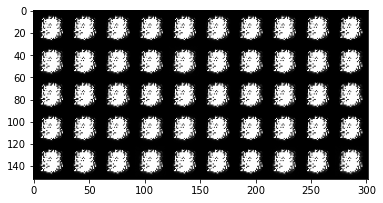

Iter: 00410/50000, Gen loss: 0.0001, Dis loss: 10.1298
Iter: 00420/50000, Gen loss: 0.0000, Dis loss: 11.3716
Iter: 00430/50000, Gen loss: 0.0001, Dis loss: 11.1407
Iter: 00440/50000, Gen loss: 0.0000, Dis loss: 12.0430
Iter: 00450/50000, Gen loss: 0.0000, Dis loss: 13.3373
Iter: 00460/50000, Gen loss: 0.0000, Dis loss: 11.9964
Iter: 00470/50000, Gen loss: 0.0001, Dis loss: 15.1666
Iter: 00480/50000, Gen loss: 0.0000, Dis loss: 14.6359
Iter: 00490/50000, Gen loss: 0.0000, Dis loss: 17.5656
Iter: 00500/50000, Gen loss: 0.0000, Dis loss: 15.6260
Iter: 00510/50000, Gen loss: 0.0000, Dis loss: 13.3104
Iter: 00520/50000, Gen loss: 0.0000, Dis loss: 12.2464
Iter: 00530/50000, Gen loss: 0.0000, Dis loss: 12.0448
Iter: 00540/50000, Gen loss: 0.0000, Dis loss: 12.1107
Iter: 00550/50000, Gen loss: 0.0000, Dis loss: 11.9996
Iter: 00560/50000, Gen loss: 0.0000, Dis loss: 12.5037
Iter: 00570/50000, Gen loss: 0.0001, Dis loss: 11.1530
Iter: 00580/50000, Gen loss: 0.0000, Dis loss: 13.1163
Iter: 0059

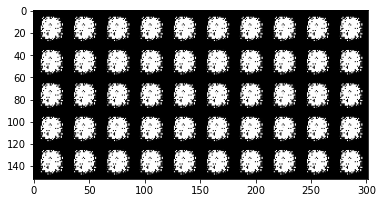

Iter: 00610/50000, Gen loss: 0.0000, Dis loss: 12.2490
Iter: 00620/50000, Gen loss: 0.0001, Dis loss: 11.5629
Iter: 00630/50000, Gen loss: 0.0000, Dis loss: 13.1762
Iter: 00640/50000, Gen loss: 0.0001, Dis loss: 8.5374
Iter: 00650/50000, Gen loss: 0.0000, Dis loss: 14.4726
Iter: 00660/50000, Gen loss: 0.0000, Dis loss: 13.5680
Iter: 00670/50000, Gen loss: 0.0000, Dis loss: 13.0395
Iter: 00680/50000, Gen loss: 0.0000, Dis loss: 12.8366
Iter: 00690/50000, Gen loss: 0.0000, Dis loss: 12.5807
Iter: 00700/50000, Gen loss: 0.0000, Dis loss: 11.8643
Iter: 00710/50000, Gen loss: 0.0000, Dis loss: 12.0694
Iter: 00720/50000, Gen loss: 0.0000, Dis loss: 12.1024
Iter: 00730/50000, Gen loss: 0.0000, Dis loss: 12.0894
Iter: 00740/50000, Gen loss: 0.0000, Dis loss: 11.6941
Iter: 00750/50000, Gen loss: 0.0000, Dis loss: 12.0821
Iter: 00760/50000, Gen loss: 0.0000, Dis loss: 15.3986
Iter: 00770/50000, Gen loss: 0.0000, Dis loss: 14.6049
Iter: 00780/50000, Gen loss: 0.0000, Dis loss: 12.8086
Iter: 00790

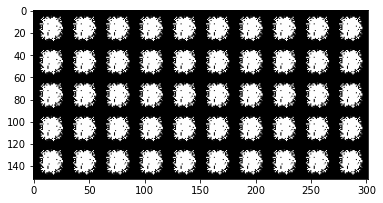

Iter: 00810/50000, Gen loss: 0.0000, Dis loss: 15.6330
Iter: 00820/50000, Gen loss: 0.0000, Dis loss: 15.1551
Iter: 00830/50000, Gen loss: 0.0000, Dis loss: 14.3258
Iter: 00840/50000, Gen loss: 0.0000, Dis loss: 14.0434
Iter: 00850/50000, Gen loss: 0.0000, Dis loss: 13.1135
Iter: 00860/50000, Gen loss: 0.0000, Dis loss: 12.1438
Iter: 00870/50000, Gen loss: 0.0000, Dis loss: 11.9857
Iter: 00880/50000, Gen loss: 0.0000, Dis loss: 11.8248
Iter: 00890/50000, Gen loss: 0.0000, Dis loss: 11.6592
Iter: 00900/50000, Gen loss: 0.0000, Dis loss: 11.8990
Iter: 00910/50000, Gen loss: 0.0000, Dis loss: 12.1334
Iter: 00920/50000, Gen loss: 0.0000, Dis loss: 12.3974
Iter: 00930/50000, Gen loss: 0.0000, Dis loss: 12.2806
Iter: 00940/50000, Gen loss: 0.0000, Dis loss: 11.9472
Iter: 00950/50000, Gen loss: 0.0000, Dis loss: 11.7868
Iter: 00960/50000, Gen loss: 0.0000, Dis loss: 12.6447
Iter: 00970/50000, Gen loss: 0.0000, Dis loss: 12.5705
Iter: 00980/50000, Gen loss: 0.0000, Dis loss: 12.9029
Iter: 0099

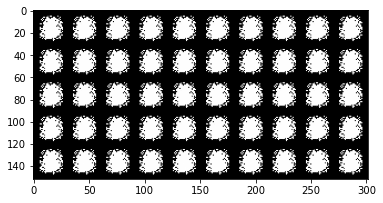

Iter: 01010/50000, Gen loss: 0.0000, Dis loss: 12.9796
Iter: 01020/50000, Gen loss: 0.0000, Dis loss: 12.6058
Iter: 01030/50000, Gen loss: 0.0000, Dis loss: 16.3794
Iter: 01040/50000, Gen loss: 0.0000, Dis loss: 12.5727
Iter: 01050/50000, Gen loss: 0.0000, Dis loss: 13.1544
Iter: 01060/50000, Gen loss: 0.0000, Dis loss: 13.1632
Iter: 01070/50000, Gen loss: 0.0000, Dis loss: 13.2399
Iter: 01080/50000, Gen loss: 0.0000, Dis loss: 13.3241
Iter: 01090/50000, Gen loss: 0.0000, Dis loss: 13.1334
Iter: 01100/50000, Gen loss: 0.0000, Dis loss: 13.2986
Iter: 01110/50000, Gen loss: 0.0000, Dis loss: 13.3631
Iter: 01120/50000, Gen loss: 0.0000, Dis loss: 13.5746
Iter: 01130/50000, Gen loss: 0.0000, Dis loss: 13.9532
Iter: 01140/50000, Gen loss: 0.0000, Dis loss: 13.4029
Iter: 01150/50000, Gen loss: 0.0000, Dis loss: 13.2442
Iter: 01160/50000, Gen loss: 0.0000, Dis loss: 16.6978
Iter: 01170/50000, Gen loss: 0.0000, Dis loss: 16.6099
Iter: 01180/50000, Gen loss: 0.0000, Dis loss: 23.0755
Iter: 0119

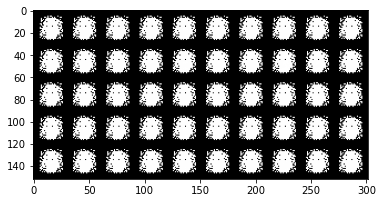

Iter: 01210/50000, Gen loss: 0.0000, Dis loss: 18.6796
Iter: 01220/50000, Gen loss: 0.0000, Dis loss: 17.9474
Iter: 01230/50000, Gen loss: 0.0000, Dis loss: 16.5003
Iter: 01240/50000, Gen loss: 0.0000, Dis loss: 14.4288
Iter: 01250/50000, Gen loss: 0.0000, Dis loss: 14.3124
Iter: 01260/50000, Gen loss: 0.0000, Dis loss: 13.9553
Iter: 01270/50000, Gen loss: 0.0000, Dis loss: 13.6311
Iter: 01280/50000, Gen loss: 0.0000, Dis loss: 14.7627
Iter: 01290/50000, Gen loss: 0.0000, Dis loss: 18.9340
Iter: 01300/50000, Gen loss: 0.0000, Dis loss: 19.1031
Iter: 01310/50000, Gen loss: 0.0000, Dis loss: 18.3626
Iter: 01320/50000, Gen loss: 0.0000, Dis loss: 17.4489
Iter: 01330/50000, Gen loss: 0.0000, Dis loss: 16.9684
Iter: 01340/50000, Gen loss: 0.0000, Dis loss: 16.4153
Iter: 01350/50000, Gen loss: 0.0000, Dis loss: 16.4583
Iter: 01360/50000, Gen loss: 0.0000, Dis loss: 13.8269
Iter: 01370/50000, Gen loss: 0.0000, Dis loss: 15.3554
Iter: 01380/50000, Gen loss: 0.0000, Dis loss: 15.3364
Iter: 0139

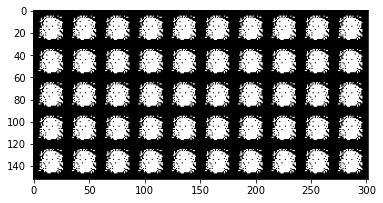

Iter: 01410/50000, Gen loss: 0.0001, Dis loss: 13.1469
Iter: 01420/50000, Gen loss: 0.0000, Dis loss: 14.8810
Iter: 01430/50000, Gen loss: 0.0000, Dis loss: 15.2741
Iter: 01440/50000, Gen loss: 0.0000, Dis loss: 15.0525
Iter: 01450/50000, Gen loss: 0.0000, Dis loss: 14.7147
Iter: 01460/50000, Gen loss: 0.0000, Dis loss: 15.3229
Iter: 01470/50000, Gen loss: 0.0000, Dis loss: 15.6937
Iter: 01480/50000, Gen loss: 0.0000, Dis loss: 15.6918
Iter: 01490/50000, Gen loss: 0.0000, Dis loss: 15.9098
Iter: 01500/50000, Gen loss: 0.0000, Dis loss: 15.8553
Iter: 01510/50000, Gen loss: 0.0000, Dis loss: 15.9275
Iter: 01520/50000, Gen loss: 0.0000, Dis loss: 14.9219
Iter: 01530/50000, Gen loss: 0.0000, Dis loss: 15.9480
Iter: 01540/50000, Gen loss: 0.0000, Dis loss: 16.3199
Iter: 01550/50000, Gen loss: 0.0000, Dis loss: 16.7180
Iter: 01560/50000, Gen loss: 0.0000, Dis loss: 15.9236
Iter: 01570/50000, Gen loss: 0.0000, Dis loss: 16.2614
Iter: 01580/50000, Gen loss: 0.0000, Dis loss: 16.3370
Iter: 0159

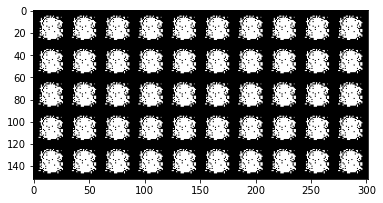

Iter: 01610/50000, Gen loss: 0.0000, Dis loss: 33.3691
Iter: 01620/50000, Gen loss: 0.0000, Dis loss: 40.2284
Iter: 01630/50000, Gen loss: 0.0000, Dis loss: 39.4913
Iter: 01640/50000, Gen loss: 0.0000, Dis loss: 39.5975
Iter: 01650/50000, Gen loss: 0.0000, Dis loss: 39.1862
Iter: 01660/50000, Gen loss: 0.0000, Dis loss: 39.1385
Iter: 01670/50000, Gen loss: 0.0000, Dis loss: 39.0126
Iter: 01680/50000, Gen loss: 0.0000, Dis loss: 39.8731
Iter: 01690/50000, Gen loss: 0.0000, Dis loss: 39.2293
Iter: 01700/50000, Gen loss: 0.0000, Dis loss: 39.1326
Iter: 01710/50000, Gen loss: 0.0000, Dis loss: 38.8327
Iter: 01720/50000, Gen loss: 0.0000, Dis loss: 38.5071
Iter: 01730/50000, Gen loss: 0.0000, Dis loss: 38.6356
Iter: 01740/50000, Gen loss: 0.0000, Dis loss: 38.8331
Iter: 01750/50000, Gen loss: 0.0000, Dis loss: 38.9990
Iter: 01760/50000, Gen loss: 0.0000, Dis loss: 39.1228
Iter: 01770/50000, Gen loss: 0.0000, Dis loss: 38.5547
Iter: 01780/50000, Gen loss: 0.0000, Dis loss: 38.4672
Iter: 0179

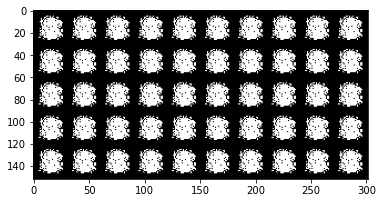

Iter: 01810/50000, Gen loss: 0.0000, Dis loss: 38.6101
Iter: 01820/50000, Gen loss: 0.0000, Dis loss: 38.6325
Iter: 01830/50000, Gen loss: 0.0000, Dis loss: 38.7840
Iter: 01840/50000, Gen loss: 0.0000, Dis loss: 38.8875
Iter: 01850/50000, Gen loss: 0.0000, Dis loss: 38.9314
Iter: 01860/50000, Gen loss: 0.0000, Dis loss: 38.9643
Iter: 01870/50000, Gen loss: 0.0000, Dis loss: 38.6473
Iter: 01880/50000, Gen loss: 0.0000, Dis loss: 38.7062
Iter: 01890/50000, Gen loss: 0.0000, Dis loss: 38.3164
Iter: 01900/50000, Gen loss: 0.0000, Dis loss: 38.5993
Iter: 01910/50000, Gen loss: 0.0000, Dis loss: 38.3998
Iter: 01920/50000, Gen loss: 0.0000, Dis loss: 37.8822
Iter: 01930/50000, Gen loss: 0.0000, Dis loss: 37.9499
Iter: 01940/50000, Gen loss: 0.0000, Dis loss: 38.5791
Iter: 01950/50000, Gen loss: 0.0000, Dis loss: 38.5351
Iter: 01960/50000, Gen loss: 0.0000, Dis loss: 38.7930
Iter: 01970/50000, Gen loss: 0.0000, Dis loss: 38.1569
Iter: 01980/50000, Gen loss: 0.0000, Dis loss: 38.7685
Iter: 0199

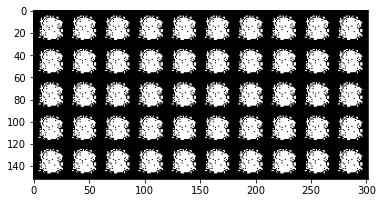

Iter: 02010/50000, Gen loss: 0.0000, Dis loss: 37.9721
Iter: 02020/50000, Gen loss: 0.0000, Dis loss: 38.4707
Iter: 02030/50000, Gen loss: 0.0000, Dis loss: 38.3180
Iter: 02040/50000, Gen loss: 0.0000, Dis loss: 38.4818
Iter: 02050/50000, Gen loss: 0.0000, Dis loss: 38.7838
Iter: 02060/50000, Gen loss: 0.0000, Dis loss: 38.1186
Iter: 02070/50000, Gen loss: 0.0000, Dis loss: 38.1922
Iter: 02080/50000, Gen loss: 0.0000, Dis loss: 38.2085
Iter: 02090/50000, Gen loss: 0.0000, Dis loss: 38.4012
Iter: 02100/50000, Gen loss: 0.0000, Dis loss: 38.1052
Iter: 02110/50000, Gen loss: 0.0000, Dis loss: 37.8560
Iter: 02120/50000, Gen loss: 0.0000, Dis loss: 37.8936
Iter: 02130/50000, Gen loss: 0.0000, Dis loss: 38.2276
Iter: 02140/50000, Gen loss: 0.0000, Dis loss: 38.3961
Iter: 02150/50000, Gen loss: 0.0000, Dis loss: 37.9274
Iter: 02160/50000, Gen loss: 0.0000, Dis loss: 38.5168
Iter: 02170/50000, Gen loss: 0.0000, Dis loss: 37.6921
Iter: 02180/50000, Gen loss: 0.0000, Dis loss: 37.4654
Iter: 0219

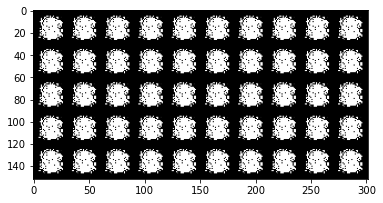

Iter: 02210/50000, Gen loss: 0.0000, Dis loss: 38.2577
Iter: 02220/50000, Gen loss: 0.0000, Dis loss: 38.2673
Iter: 02230/50000, Gen loss: 0.0000, Dis loss: 37.9473
Iter: 02240/50000, Gen loss: 0.0000, Dis loss: 38.2649
Iter: 02250/50000, Gen loss: 0.0000, Dis loss: 37.2107
Iter: 02260/50000, Gen loss: 0.0000, Dis loss: 38.0156
Iter: 02270/50000, Gen loss: 0.0000, Dis loss: 38.2632
Iter: 02280/50000, Gen loss: 0.0000, Dis loss: 38.5395
Iter: 02290/50000, Gen loss: 0.0000, Dis loss: 38.5979
Iter: 02300/50000, Gen loss: 0.0000, Dis loss: 38.0043
Iter: 02310/50000, Gen loss: 0.0000, Dis loss: 38.2361
Iter: 02320/50000, Gen loss: 0.0000, Dis loss: 37.7812
Iter: 02330/50000, Gen loss: 0.0000, Dis loss: 38.1389
Iter: 02340/50000, Gen loss: 0.0000, Dis loss: 38.2742
Iter: 02350/50000, Gen loss: 0.0000, Dis loss: 38.0427
Iter: 02360/50000, Gen loss: 0.0000, Dis loss: 37.9424
Iter: 02370/50000, Gen loss: 0.0000, Dis loss: 37.5354
Iter: 02380/50000, Gen loss: 0.0000, Dis loss: 38.2435
Iter: 0239

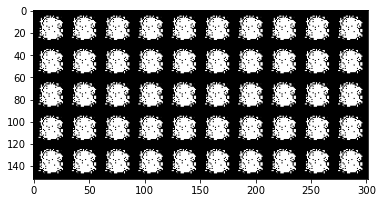

Iter: 02410/50000, Gen loss: 0.0000, Dis loss: 38.4081
Iter: 02420/50000, Gen loss: 0.0000, Dis loss: 38.4138
Iter: 02430/50000, Gen loss: 0.0000, Dis loss: 38.2292
Iter: 02440/50000, Gen loss: 0.0000, Dis loss: 38.5946
Iter: 02450/50000, Gen loss: 0.0000, Dis loss: 38.5832
Iter: 02460/50000, Gen loss: 0.0000, Dis loss: 38.4686
Iter: 02470/50000, Gen loss: 0.0000, Dis loss: 38.1892
Iter: 02480/50000, Gen loss: 0.0000, Dis loss: 37.8814
Iter: 02490/50000, Gen loss: 0.0000, Dis loss: 37.9688
Iter: 02500/50000, Gen loss: 0.0000, Dis loss: 38.3260
Iter: 02510/50000, Gen loss: 0.0000, Dis loss: 38.2185
Iter: 02520/50000, Gen loss: 0.0000, Dis loss: 38.1225
Iter: 02530/50000, Gen loss: 0.0000, Dis loss: 37.7510
Iter: 02540/50000, Gen loss: 0.0000, Dis loss: 37.7686
Iter: 02550/50000, Gen loss: 0.0000, Dis loss: 37.8204
Iter: 02560/50000, Gen loss: 0.0000, Dis loss: 38.3712
Iter: 02570/50000, Gen loss: 0.0000, Dis loss: 37.9907
Iter: 02580/50000, Gen loss: 0.0000, Dis loss: 38.3798
Iter: 0259

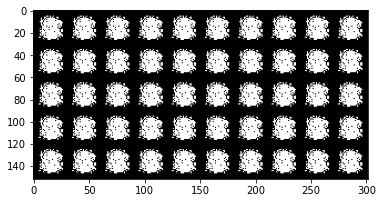

Iter: 02610/50000, Gen loss: 0.0000, Dis loss: 38.2460
Iter: 02620/50000, Gen loss: 0.0000, Dis loss: 37.9596
Iter: 02630/50000, Gen loss: 0.0000, Dis loss: 37.9058
Iter: 02640/50000, Gen loss: 0.0000, Dis loss: 37.9048
Iter: 02650/50000, Gen loss: 0.0000, Dis loss: 37.8938
Iter: 02660/50000, Gen loss: 0.0000, Dis loss: 38.0894
Iter: 02670/50000, Gen loss: 0.0000, Dis loss: 37.9472
Iter: 02680/50000, Gen loss: 0.0000, Dis loss: 37.9414
Iter: 02690/50000, Gen loss: 0.0000, Dis loss: 38.1964
Iter: 02700/50000, Gen loss: 0.0000, Dis loss: 38.2580
Iter: 02710/50000, Gen loss: 0.0000, Dis loss: 38.1430
Iter: 02720/50000, Gen loss: 0.0000, Dis loss: 37.7392
Iter: 02730/50000, Gen loss: 0.0000, Dis loss: 38.0001
Iter: 02740/50000, Gen loss: 0.0000, Dis loss: 37.9678
Iter: 02750/50000, Gen loss: 0.0000, Dis loss: 37.4827
Iter: 02760/50000, Gen loss: 0.0000, Dis loss: 37.8012
Iter: 02770/50000, Gen loss: 0.0000, Dis loss: 37.8338
Iter: 02780/50000, Gen loss: 0.0000, Dis loss: 37.8865
Iter: 0279

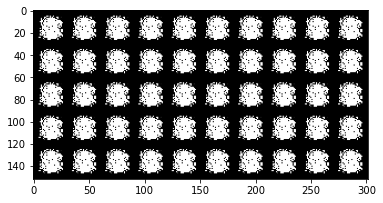

Iter: 02810/50000, Gen loss: 0.0000, Dis loss: 38.1021
Iter: 02820/50000, Gen loss: 0.0000, Dis loss: 37.6682
Iter: 02830/50000, Gen loss: 0.0000, Dis loss: 37.9999
Iter: 02840/50000, Gen loss: 0.0000, Dis loss: 37.9463
Iter: 02850/50000, Gen loss: 0.0000, Dis loss: 37.5894
Iter: 02860/50000, Gen loss: 0.0000, Dis loss: 37.2624
Iter: 02870/50000, Gen loss: 0.0000, Dis loss: 37.5275
Iter: 02880/50000, Gen loss: 0.0000, Dis loss: 37.4672
Iter: 02890/50000, Gen loss: 0.0000, Dis loss: 37.5125
Iter: 02900/50000, Gen loss: 0.0000, Dis loss: 37.8729
Iter: 02910/50000, Gen loss: 0.0000, Dis loss: 37.7115
Iter: 02920/50000, Gen loss: 0.0000, Dis loss: 37.4867
Iter: 02930/50000, Gen loss: 0.0000, Dis loss: 37.5992
Iter: 02940/50000, Gen loss: 0.0000, Dis loss: 37.6596
Iter: 02950/50000, Gen loss: 0.0000, Dis loss: 37.7445
Iter: 02960/50000, Gen loss: 0.0000, Dis loss: 37.3176
Iter: 02970/50000, Gen loss: 0.0000, Dis loss: 37.7898
Iter: 02980/50000, Gen loss: 0.0000, Dis loss: 38.1463
Iter: 0299

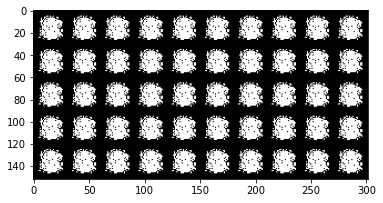

Iter: 03010/50000, Gen loss: 0.0000, Dis loss: 37.3900
Iter: 03020/50000, Gen loss: 0.0000, Dis loss: 38.4729
Iter: 03030/50000, Gen loss: 0.0000, Dis loss: 37.6169
Iter: 03040/50000, Gen loss: 0.0000, Dis loss: 37.7812
Iter: 03050/50000, Gen loss: 0.0000, Dis loss: 37.2168
Iter: 03060/50000, Gen loss: 0.0000, Dis loss: 37.7786
Iter: 03070/50000, Gen loss: 0.0000, Dis loss: 37.7547
Iter: 03080/50000, Gen loss: 0.0000, Dis loss: 37.8438
Iter: 03090/50000, Gen loss: 0.0000, Dis loss: 37.3266
Iter: 03100/50000, Gen loss: 0.0000, Dis loss: 37.2726
Iter: 03110/50000, Gen loss: 0.0000, Dis loss: 38.0080
Iter: 03120/50000, Gen loss: 0.0000, Dis loss: 37.4679
Iter: 03130/50000, Gen loss: 0.0000, Dis loss: 37.4936
Iter: 03140/50000, Gen loss: 0.0000, Dis loss: 37.5043
Iter: 03150/50000, Gen loss: 0.0000, Dis loss: 37.5570
Iter: 03160/50000, Gen loss: 0.0000, Dis loss: 37.2137
Iter: 03170/50000, Gen loss: 0.0000, Dis loss: 37.0707
Iter: 03180/50000, Gen loss: 0.0000, Dis loss: 37.8941
Iter: 0319

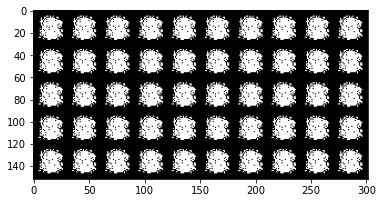

Iter: 03210/50000, Gen loss: 0.0000, Dis loss: 37.3282
Iter: 03220/50000, Gen loss: 0.0000, Dis loss: 37.3035
Iter: 03230/50000, Gen loss: 0.0000, Dis loss: 37.2055
Iter: 03240/50000, Gen loss: 0.0000, Dis loss: 37.1954
Iter: 03250/50000, Gen loss: 0.0000, Dis loss: 37.0358
Iter: 03260/50000, Gen loss: 0.0000, Dis loss: 37.6246
Iter: 03270/50000, Gen loss: 0.0000, Dis loss: 37.2319
Iter: 03280/50000, Gen loss: 0.0000, Dis loss: 37.4195
Iter: 03290/50000, Gen loss: 0.0000, Dis loss: 37.4086
Iter: 03300/50000, Gen loss: 0.0000, Dis loss: 37.3675
Iter: 03310/50000, Gen loss: 0.0000, Dis loss: 37.1776
Iter: 03320/50000, Gen loss: 0.0000, Dis loss: 37.5454
Iter: 03330/50000, Gen loss: 0.0000, Dis loss: 37.1153
Iter: 03340/50000, Gen loss: 0.0000, Dis loss: 37.0343
Iter: 03350/50000, Gen loss: 0.0000, Dis loss: 36.7412
Iter: 03360/50000, Gen loss: 0.0000, Dis loss: 36.8151
Iter: 03370/50000, Gen loss: 0.0000, Dis loss: 36.9874
Iter: 03380/50000, Gen loss: 0.0000, Dis loss: 37.4193
Iter: 0339

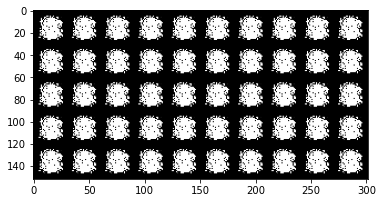

Iter: 03410/50000, Gen loss: 0.0000, Dis loss: 36.9634
Iter: 03420/50000, Gen loss: 0.0000, Dis loss: 37.2003
Iter: 03430/50000, Gen loss: 0.0000, Dis loss: 37.5859
Iter: 03440/50000, Gen loss: 0.0000, Dis loss: 37.4578
Iter: 03450/50000, Gen loss: 0.0000, Dis loss: 37.7265
Iter: 03460/50000, Gen loss: 0.0000, Dis loss: 36.9235
Iter: 03470/50000, Gen loss: 0.0000, Dis loss: 37.3923
Iter: 03480/50000, Gen loss: 0.0000, Dis loss: 36.6806
Iter: 03490/50000, Gen loss: 0.0000, Dis loss: 36.8337
Iter: 03500/50000, Gen loss: 0.0000, Dis loss: 36.9145
Iter: 03510/50000, Gen loss: 0.0000, Dis loss: 37.1112
Iter: 03520/50000, Gen loss: 0.0000, Dis loss: 36.9019
Iter: 03530/50000, Gen loss: 0.0000, Dis loss: 37.1744
Iter: 03540/50000, Gen loss: 0.0000, Dis loss: 37.0601
Iter: 03550/50000, Gen loss: 0.0000, Dis loss: 36.7206
Iter: 03560/50000, Gen loss: 0.0000, Dis loss: 36.7008
Iter: 03570/50000, Gen loss: 0.0000, Dis loss: 37.0208
Iter: 03580/50000, Gen loss: 0.0000, Dis loss: 37.2785
Iter: 0359

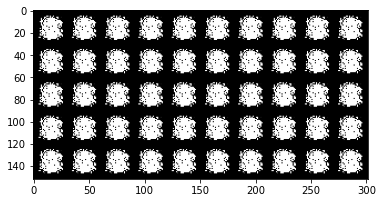

Iter: 03610/50000, Gen loss: 0.0000, Dis loss: 37.0866
Iter: 03620/50000, Gen loss: 0.0000, Dis loss: 36.5724
Iter: 03630/50000, Gen loss: 0.0000, Dis loss: 36.8102
Iter: 03640/50000, Gen loss: 0.0000, Dis loss: 36.9380
Iter: 03650/50000, Gen loss: 0.0000, Dis loss: 37.2789
Iter: 03660/50000, Gen loss: 0.0000, Dis loss: 37.1816
Iter: 03670/50000, Gen loss: 0.0000, Dis loss: 36.9821
Iter: 03680/50000, Gen loss: 0.0000, Dis loss: 37.2367
Iter: 03690/50000, Gen loss: 0.0000, Dis loss: 37.1718
Iter: 03700/50000, Gen loss: 0.0000, Dis loss: 37.1422
Iter: 03710/50000, Gen loss: 0.0000, Dis loss: 36.8016
Iter: 03720/50000, Gen loss: 0.0000, Dis loss: 37.2742
Iter: 03730/50000, Gen loss: 0.0000, Dis loss: 36.9112
Iter: 03740/50000, Gen loss: 0.0000, Dis loss: 36.8893
Iter: 03750/50000, Gen loss: 0.0000, Dis loss: 36.5162
Iter: 03760/50000, Gen loss: 0.0000, Dis loss: 36.5398
Iter: 03770/50000, Gen loss: 0.0000, Dis loss: 36.3805
Iter: 03780/50000, Gen loss: 0.0000, Dis loss: 36.3722
Iter: 0379

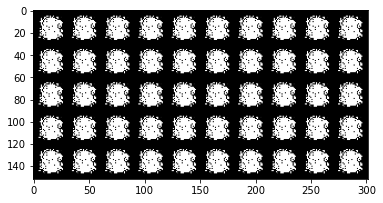

Iter: 03810/50000, Gen loss: 0.0000, Dis loss: 37.0776
Iter: 03820/50000, Gen loss: 0.0000, Dis loss: 37.0251
Iter: 03830/50000, Gen loss: 0.0000, Dis loss: 36.7212
Iter: 03840/50000, Gen loss: 0.0000, Dis loss: 37.1155
Iter: 03850/50000, Gen loss: 0.0000, Dis loss: 36.8542
Iter: 03860/50000, Gen loss: 0.0000, Dis loss: 36.3105
Iter: 03870/50000, Gen loss: 0.0000, Dis loss: 36.4775
Iter: 03880/50000, Gen loss: 0.0000, Dis loss: 36.3467
Iter: 03890/50000, Gen loss: 0.0000, Dis loss: 36.8252
Iter: 03900/50000, Gen loss: 0.0000, Dis loss: 36.5872
Iter: 03910/50000, Gen loss: 0.0000, Dis loss: 36.5534
Iter: 03920/50000, Gen loss: 0.0000, Dis loss: 36.2463
Iter: 03930/50000, Gen loss: 0.0000, Dis loss: 36.4981
Iter: 03940/50000, Gen loss: 0.0000, Dis loss: 36.6466
Iter: 03950/50000, Gen loss: 0.0000, Dis loss: 36.7188
Iter: 03960/50000, Gen loss: 0.0000, Dis loss: 36.6926
Iter: 03970/50000, Gen loss: 0.0000, Dis loss: 36.2207
Iter: 03980/50000, Gen loss: 0.0000, Dis loss: 36.7443
Iter: 0399

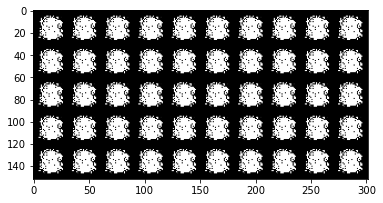

Iter: 04010/50000, Gen loss: 0.0000, Dis loss: 36.4607
Iter: 04020/50000, Gen loss: 0.0000, Dis loss: 36.6088
Iter: 04030/50000, Gen loss: 0.0000, Dis loss: 36.5328
Iter: 04040/50000, Gen loss: 0.0000, Dis loss: 36.2967
Iter: 04050/50000, Gen loss: 0.0000, Dis loss: 36.2702
Iter: 04060/50000, Gen loss: 0.0000, Dis loss: 35.8569
Iter: 04070/50000, Gen loss: 0.0000, Dis loss: 36.1701
Iter: 04080/50000, Gen loss: 0.0000, Dis loss: 36.6157
Iter: 04090/50000, Gen loss: 0.0000, Dis loss: 36.2816
Iter: 04100/50000, Gen loss: 0.0000, Dis loss: 35.9694
Iter: 04110/50000, Gen loss: 0.0000, Dis loss: 36.2461
Iter: 04120/50000, Gen loss: 0.0000, Dis loss: 35.6637
Iter: 04130/50000, Gen loss: 0.0000, Dis loss: 36.4182
Iter: 04140/50000, Gen loss: 0.0000, Dis loss: 36.3074
Iter: 04150/50000, Gen loss: 0.0000, Dis loss: 36.4158
Iter: 04160/50000, Gen loss: 0.0000, Dis loss: 36.3305
Iter: 04170/50000, Gen loss: 0.0000, Dis loss: 36.3823
Iter: 04180/50000, Gen loss: 0.0000, Dis loss: 36.2929
Iter: 0419

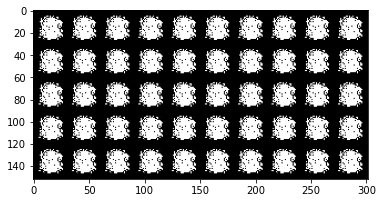

Iter: 04210/50000, Gen loss: 0.0000, Dis loss: 35.9125
Iter: 04220/50000, Gen loss: 0.0000, Dis loss: 36.2232
Iter: 04230/50000, Gen loss: 0.0000, Dis loss: 35.9163
Iter: 04240/50000, Gen loss: 0.0000, Dis loss: 36.3194
Iter: 04250/50000, Gen loss: 0.0000, Dis loss: 36.4175
Iter: 04260/50000, Gen loss: 0.0000, Dis loss: 36.2326
Iter: 04270/50000, Gen loss: 0.0000, Dis loss: 36.1881
Iter: 04280/50000, Gen loss: 0.0000, Dis loss: 35.8015
Iter: 04290/50000, Gen loss: 0.0000, Dis loss: 36.2651
Iter: 04300/50000, Gen loss: 0.0000, Dis loss: 36.4058
Iter: 04310/50000, Gen loss: 0.0000, Dis loss: 35.5377
Iter: 04320/50000, Gen loss: 0.0000, Dis loss: 36.0955
Iter: 04330/50000, Gen loss: 0.0000, Dis loss: 36.2526
Iter: 04340/50000, Gen loss: 0.0000, Dis loss: 35.9765
Iter: 04350/50000, Gen loss: 0.0000, Dis loss: 36.0036
Iter: 04360/50000, Gen loss: 0.0000, Dis loss: 35.9773
Iter: 04370/50000, Gen loss: 0.0000, Dis loss: 35.8041
Iter: 04380/50000, Gen loss: 0.0000, Dis loss: 36.2391
Iter: 0439

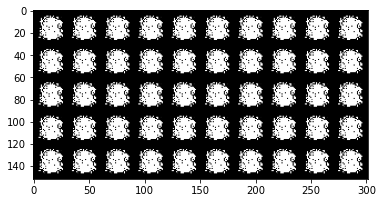

Iter: 04410/50000, Gen loss: 0.0000, Dis loss: 36.2008
Iter: 04420/50000, Gen loss: 0.0000, Dis loss: 35.7900
Iter: 04430/50000, Gen loss: 0.0000, Dis loss: 35.9585
Iter: 04440/50000, Gen loss: 0.0000, Dis loss: 35.9333
Iter: 04450/50000, Gen loss: 0.0000, Dis loss: 35.9564
Iter: 04460/50000, Gen loss: 0.0000, Dis loss: 35.5343
Iter: 04470/50000, Gen loss: 0.0000, Dis loss: 35.8465
Iter: 04480/50000, Gen loss: 0.0000, Dis loss: 36.3568
Iter: 04490/50000, Gen loss: 0.0000, Dis loss: 35.9110
Iter: 04500/50000, Gen loss: 0.0000, Dis loss: 35.9643
Iter: 04510/50000, Gen loss: 0.0000, Dis loss: 36.1223
Iter: 04520/50000, Gen loss: 0.0000, Dis loss: 35.2431
Iter: 04530/50000, Gen loss: 0.0000, Dis loss: 35.8291
Iter: 04540/50000, Gen loss: 0.0000, Dis loss: 35.6309
Iter: 04550/50000, Gen loss: 0.0000, Dis loss: 36.0351
Iter: 04560/50000, Gen loss: 0.0000, Dis loss: 35.5627
Iter: 04570/50000, Gen loss: 0.0000, Dis loss: 35.5453
Iter: 04580/50000, Gen loss: 0.0000, Dis loss: 35.6224
Iter: 0459

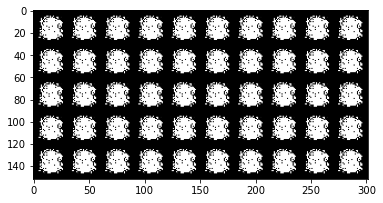

Iter: 04610/50000, Gen loss: 0.0000, Dis loss: 35.1592
Iter: 04620/50000, Gen loss: 0.0000, Dis loss: 35.2561
Iter: 04630/50000, Gen loss: 0.0000, Dis loss: 35.2862
Iter: 04640/50000, Gen loss: 0.0000, Dis loss: 34.3594
Iter: 04650/50000, Gen loss: 0.0000, Dis loss: 34.6267
Iter: 04660/50000, Gen loss: 0.0000, Dis loss: 34.4933
Iter: 04670/50000, Gen loss: 0.0000, Dis loss: 34.0642
Iter: 04680/50000, Gen loss: 0.0000, Dis loss: 34.1146
Iter: 04690/50000, Gen loss: 0.0000, Dis loss: 33.5999
Iter: 04700/50000, Gen loss: 0.0000, Dis loss: 33.3155
Iter: 04710/50000, Gen loss: 0.0000, Dis loss: 33.1796
Iter: 04720/50000, Gen loss: 0.0000, Dis loss: 33.3790
Iter: 04730/50000, Gen loss: 0.0000, Dis loss: 33.3411
Iter: 04740/50000, Gen loss: 0.0000, Dis loss: 33.3688
Iter: 04750/50000, Gen loss: 0.0000, Dis loss: 32.9967
Iter: 04760/50000, Gen loss: 0.0000, Dis loss: 32.9933
Iter: 04770/50000, Gen loss: 0.0000, Dis loss: 32.8231
Iter: 04780/50000, Gen loss: 0.0000, Dis loss: 32.6838
Iter: 0479

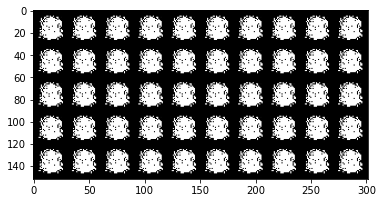

Iter: 04810/50000, Gen loss: 0.0000, Dis loss: 32.5787
Iter: 04820/50000, Gen loss: 0.0000, Dis loss: 32.2750
Iter: 04830/50000, Gen loss: 0.0000, Dis loss: 31.4173
Iter: 04840/50000, Gen loss: 0.0000, Dis loss: 31.4409
Iter: 04850/50000, Gen loss: 0.0000, Dis loss: 30.6772
Iter: 04860/50000, Gen loss: 0.0000, Dis loss: 31.2483
Iter: 04870/50000, Gen loss: 0.0000, Dis loss: 30.9281
Iter: 04880/50000, Gen loss: 0.0000, Dis loss: 30.7827
Iter: 04890/50000, Gen loss: 0.0000, Dis loss: 30.3293
Iter: 04900/50000, Gen loss: 0.0000, Dis loss: 30.0896
Iter: 04910/50000, Gen loss: 0.0000, Dis loss: 29.1273
Iter: 04920/50000, Gen loss: 0.0000, Dis loss: 27.9183
Iter: 04930/50000, Gen loss: 0.0000, Dis loss: 26.8911
Iter: 04940/50000, Gen loss: 0.0000, Dis loss: 25.2939
Iter: 04950/50000, Gen loss: 0.0000, Dis loss: 22.8679
Iter: 04960/50000, Gen loss: 0.0000, Dis loss: 21.4596
Iter: 04970/50000, Gen loss: 0.0000, Dis loss: 20.5075
Iter: 04980/50000, Gen loss: 0.0000, Dis loss: 20.8799
Iter: 0499

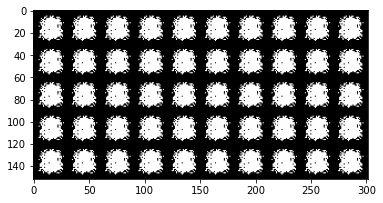

Iter: 05010/50000, Gen loss: 0.0000, Dis loss: 21.5117
Iter: 05020/50000, Gen loss: 0.0000, Dis loss: 21.8383
Iter: 05030/50000, Gen loss: 0.0000, Dis loss: 21.8051
Iter: 05040/50000, Gen loss: 0.0000, Dis loss: 22.6910
Iter: 05050/50000, Gen loss: 0.0000, Dis loss: 28.6329
Iter: 05060/50000, Gen loss: 0.0000, Dis loss: 35.6986
Iter: 05070/50000, Gen loss: 0.0000, Dis loss: 18.2035
Iter: 05080/50000, Gen loss: 0.0000, Dis loss: 21.6652
Iter: 05090/50000, Gen loss: 0.0000, Dis loss: 26.4039
Iter: 05100/50000, Gen loss: 0.0000, Dis loss: 24.2773
Iter: 05110/50000, Gen loss: 0.0000, Dis loss: 21.7024
Iter: 05120/50000, Gen loss: 0.0000, Dis loss: 30.2841
Iter: 05130/50000, Gen loss: 0.0000, Dis loss: 36.0705
Iter: 05140/50000, Gen loss: 0.0000, Dis loss: 35.4137
Iter: 05150/50000, Gen loss: 0.0000, Dis loss: 33.3144
Iter: 05160/50000, Gen loss: 0.0000, Dis loss: 29.2151
Iter: 05170/50000, Gen loss: 0.0000, Dis loss: 27.2983
Iter: 05180/50000, Gen loss: 0.0000, Dis loss: 26.5780
Iter: 0519

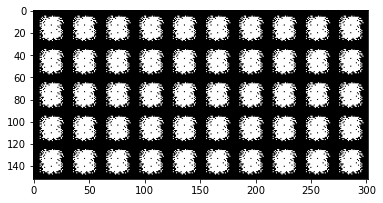

Iter: 05210/50000, Gen loss: 0.0000, Dis loss: 18.3556
Iter: 05220/50000, Gen loss: 0.0000, Dis loss: 18.4570
Iter: 05230/50000, Gen loss: 0.0000, Dis loss: 19.4525
Iter: 05240/50000, Gen loss: 0.0000, Dis loss: 18.3871
Iter: 05250/50000, Gen loss: 0.0000, Dis loss: 17.2339
Iter: 05260/50000, Gen loss: 0.0000, Dis loss: 19.4449
Iter: 05270/50000, Gen loss: 0.0000, Dis loss: 24.1893
Iter: 05280/50000, Gen loss: 0.0000, Dis loss: 24.2083
Iter: 05290/50000, Gen loss: 0.0000, Dis loss: 23.3114
Iter: 05300/50000, Gen loss: 0.0000, Dis loss: 23.0738
Iter: 05310/50000, Gen loss: 0.0000, Dis loss: 48.1716
Iter: 05320/50000, Gen loss: 0.0000, Dis loss: 20.7870
Iter: 05330/50000, Gen loss: 0.0000, Dis loss: 20.9754
Iter: 05340/50000, Gen loss: 0.0000, Dis loss: 22.2768
Iter: 05350/50000, Gen loss: 0.0000, Dis loss: 22.7446
Iter: 05360/50000, Gen loss: 0.0000, Dis loss: 22.0509
Iter: 05370/50000, Gen loss: 0.0000, Dis loss: 21.5453
Iter: 05380/50000, Gen loss: 0.0000, Dis loss: 21.2289
Iter: 0539

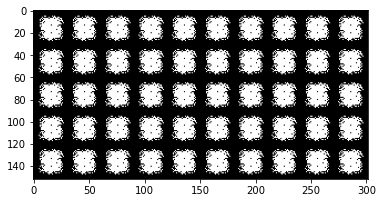

Iter: 05410/50000, Gen loss: 0.0000, Dis loss: 21.3405
Iter: 05420/50000, Gen loss: 0.0000, Dis loss: 21.6051
Iter: 05430/50000, Gen loss: 0.0000, Dis loss: 22.0945
Iter: 05440/50000, Gen loss: 0.0000, Dis loss: 21.2394
Iter: 05450/50000, Gen loss: 0.0000, Dis loss: 20.7404
Iter: 05460/50000, Gen loss: 0.0000, Dis loss: 20.4301
Iter: 05470/50000, Gen loss: 0.0000, Dis loss: 22.3341
Iter: 05480/50000, Gen loss: 0.0000, Dis loss: 22.2700
Iter: 05490/50000, Gen loss: 0.0000, Dis loss: 21.1445
Iter: 05500/50000, Gen loss: 0.0000, Dis loss: 36.3941
Iter: 05510/50000, Gen loss: 0.0000, Dis loss: 30.8824
Iter: 05520/50000, Gen loss: 0.0000, Dis loss: 29.7193
Iter: 05530/50000, Gen loss: 0.0000, Dis loss: 28.7415
Iter: 05540/50000, Gen loss: 0.0000, Dis loss: 28.2560
Iter: 05550/50000, Gen loss: 0.0000, Dis loss: 26.9227
Iter: 05560/50000, Gen loss: 0.0000, Dis loss: 26.9815
Iter: 05570/50000, Gen loss: 0.0000, Dis loss: 27.2480
Iter: 05580/50000, Gen loss: 0.0000, Dis loss: 27.4333
Iter: 0559

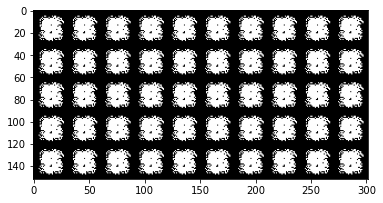

Iter: 05610/50000, Gen loss: 0.0000, Dis loss: 26.2669
Iter: 05620/50000, Gen loss: 0.0000, Dis loss: 25.8485
Iter: 05630/50000, Gen loss: 0.0000, Dis loss: 25.3006
Iter: 05640/50000, Gen loss: 0.0000, Dis loss: 24.5865
Iter: 05650/50000, Gen loss: 0.0000, Dis loss: 24.9548
Iter: 05660/50000, Gen loss: 0.0000, Dis loss: 24.7067
Iter: 05670/50000, Gen loss: 0.0000, Dis loss: 24.0728
Iter: 05680/50000, Gen loss: 0.0000, Dis loss: 50.2448
Iter: 05690/50000, Gen loss: 0.0000, Dis loss: 18.4456
Iter: 05700/50000, Gen loss: 0.0000, Dis loss: 18.6859
Iter: 05710/50000, Gen loss: 0.0000, Dis loss: 18.0039
Iter: 05720/50000, Gen loss: 0.0000, Dis loss: 15.7909
Iter: 05730/50000, Gen loss: 0.0000, Dis loss: 15.6352
Iter: 05740/50000, Gen loss: 0.0000, Dis loss: 14.9254
Iter: 05750/50000, Gen loss: 0.0000, Dis loss: 15.5399
Iter: 05760/50000, Gen loss: 0.0000, Dis loss: 15.9514
Iter: 05770/50000, Gen loss: 0.0000, Dis loss: 15.6623
Iter: 05780/50000, Gen loss: 0.0000, Dis loss: 16.0142
Iter: 0579

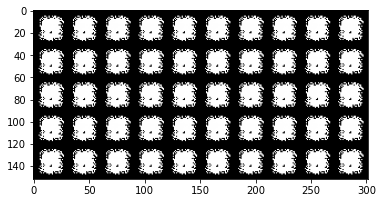

Iter: 05810/50000, Gen loss: 0.0000, Dis loss: 14.5513
Iter: 05820/50000, Gen loss: 0.0000, Dis loss: 14.5370
Iter: 05830/50000, Gen loss: 0.0000, Dis loss: 15.8903
Iter: 05840/50000, Gen loss: 0.0000, Dis loss: 16.3826
Iter: 05850/50000, Gen loss: 0.0000, Dis loss: 16.3744
Iter: 05860/50000, Gen loss: 0.0000, Dis loss: 16.6531
Iter: 05870/50000, Gen loss: 0.0000, Dis loss: 16.1807
Iter: 05880/50000, Gen loss: 0.0000, Dis loss: 14.2605
Iter: 05890/50000, Gen loss: 0.0000, Dis loss: 15.8109
Iter: 05900/50000, Gen loss: 0.0000, Dis loss: 16.3589
Iter: 05910/50000, Gen loss: 0.0000, Dis loss: 15.6843
Iter: 05920/50000, Gen loss: 0.0000, Dis loss: 15.3517
Iter: 05930/50000, Gen loss: 0.0000, Dis loss: 16.6216
Iter: 05940/50000, Gen loss: 0.0000, Dis loss: 16.6334
Iter: 05950/50000, Gen loss: 0.0000, Dis loss: 17.0088
Iter: 05960/50000, Gen loss: 0.0000, Dis loss: 19.0492
Iter: 05970/50000, Gen loss: 0.0000, Dis loss: 15.3544
Iter: 05980/50000, Gen loss: 0.0000, Dis loss: 22.5611
Iter: 0599

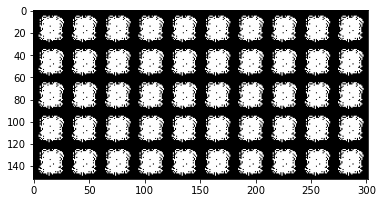

Iter: 06010/50000, Gen loss: 0.0000, Dis loss: 21.1815
Iter: 06020/50000, Gen loss: 0.0000, Dis loss: 19.2946
Iter: 06030/50000, Gen loss: 0.0000, Dis loss: 18.9233
Iter: 06040/50000, Gen loss: 0.0000, Dis loss: 20.2296
Iter: 06050/50000, Gen loss: 0.0000, Dis loss: 20.1682
Iter: 06060/50000, Gen loss: 0.0000, Dis loss: 20.6523
Iter: 06070/50000, Gen loss: 0.0000, Dis loss: 20.7295
Iter: 06080/50000, Gen loss: 0.0000, Dis loss: 20.0639
Iter: 06090/50000, Gen loss: 0.0000, Dis loss: 19.9110
Iter: 06100/50000, Gen loss: 0.0000, Dis loss: 21.0574
Iter: 06110/50000, Gen loss: 0.0000, Dis loss: 21.2299
Iter: 06120/50000, Gen loss: 0.0000, Dis loss: 24.1560
Iter: 06130/50000, Gen loss: 0.0000, Dis loss: 23.8362
Iter: 06140/50000, Gen loss: 0.0000, Dis loss: 22.9957
Iter: 06150/50000, Gen loss: 0.0000, Dis loss: 22.3067
Iter: 06160/50000, Gen loss: 0.0000, Dis loss: 22.9007
Iter: 06170/50000, Gen loss: 0.0000, Dis loss: 22.7027
Iter: 06180/50000, Gen loss: 0.0000, Dis loss: 23.4820
Iter: 0619

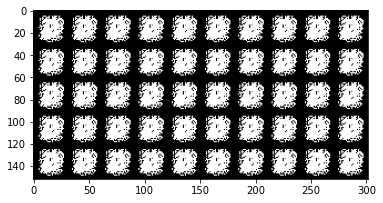

Iter: 06210/50000, Gen loss: 0.0000, Dis loss: 33.0094
Iter: 06220/50000, Gen loss: 0.0000, Dis loss: 33.1084
Iter: 06230/50000, Gen loss: 0.0000, Dis loss: 32.6975
Iter: 06240/50000, Gen loss: 0.0000, Dis loss: 32.4911
Iter: 06250/50000, Gen loss: 0.0000, Dis loss: 31.9984
Iter: 06260/50000, Gen loss: 0.0000, Dis loss: 30.5369
Iter: 06270/50000, Gen loss: 0.0000, Dis loss: 29.5328
Iter: 06280/50000, Gen loss: 0.0000, Dis loss: 30.0757
Iter: 06290/50000, Gen loss: 0.0000, Dis loss: 28.4404
Iter: 06300/50000, Gen loss: 0.0000, Dis loss: 27.5249
Iter: 06310/50000, Gen loss: 0.0000, Dis loss: 26.9152
Iter: 06320/50000, Gen loss: 0.0000, Dis loss: 27.3276
Iter: 06330/50000, Gen loss: 0.0000, Dis loss: 26.9224
Iter: 06340/50000, Gen loss: 0.0000, Dis loss: 26.8493
Iter: 06350/50000, Gen loss: 0.0000, Dis loss: 26.5592
Iter: 06360/50000, Gen loss: 0.0000, Dis loss: 26.3049
Iter: 06370/50000, Gen loss: 0.0000, Dis loss: 26.0616
Iter: 06380/50000, Gen loss: 0.0000, Dis loss: 25.0649
Iter: 0639

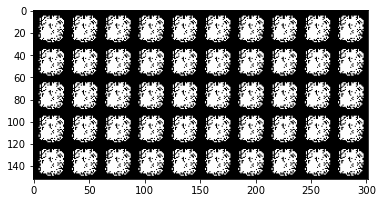

Iter: 06410/50000, Gen loss: 0.0000, Dis loss: 25.8803
Iter: 06420/50000, Gen loss: 0.0000, Dis loss: 25.5929
Iter: 06430/50000, Gen loss: 0.0000, Dis loss: 24.9788
Iter: 06440/50000, Gen loss: 0.0000, Dis loss: 25.5313
Iter: 06450/50000, Gen loss: 0.0000, Dis loss: 26.9982
Iter: 06460/50000, Gen loss: 0.0000, Dis loss: 26.9503
Iter: 06470/50000, Gen loss: 0.0000, Dis loss: 27.2154
Iter: 06480/50000, Gen loss: 0.0000, Dis loss: 26.9400
Iter: 06490/50000, Gen loss: 0.0000, Dis loss: 27.5999
Iter: 06500/50000, Gen loss: 0.0000, Dis loss: 26.2373
Iter: 06510/50000, Gen loss: 0.0000, Dis loss: 26.2442
Iter: 06520/50000, Gen loss: 0.0000, Dis loss: 25.9363
Iter: 06530/50000, Gen loss: 0.0000, Dis loss: 26.6483
Iter: 06540/50000, Gen loss: 0.0000, Dis loss: 26.7727
Iter: 06550/50000, Gen loss: 0.0000, Dis loss: 26.6470
Iter: 06560/50000, Gen loss: 0.0000, Dis loss: 26.1578
Iter: 06570/50000, Gen loss: 0.0000, Dis loss: 26.4263
Iter: 06580/50000, Gen loss: 0.0000, Dis loss: 25.6698
Iter: 0659

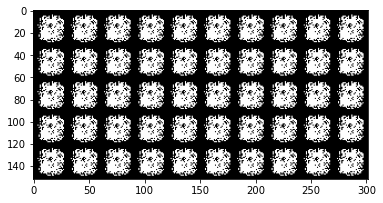

Iter: 06610/50000, Gen loss: 0.0000, Dis loss: 26.8522
Iter: 06620/50000, Gen loss: 0.0000, Dis loss: 27.1676
Iter: 06630/50000, Gen loss: 0.0000, Dis loss: 27.8505
Iter: 06640/50000, Gen loss: 0.0000, Dis loss: 27.6061
Iter: 06650/50000, Gen loss: 0.0000, Dis loss: 27.9981
Iter: 06660/50000, Gen loss: 0.0000, Dis loss: 27.1855
Iter: 06670/50000, Gen loss: 0.0000, Dis loss: 27.0913
Iter: 06680/50000, Gen loss: 0.0000, Dis loss: 25.9617
Iter: 06690/50000, Gen loss: 0.0000, Dis loss: 26.3720
Iter: 06700/50000, Gen loss: 0.0000, Dis loss: 25.7956
Iter: 06710/50000, Gen loss: 0.0000, Dis loss: 26.9644
Iter: 06720/50000, Gen loss: 0.0000, Dis loss: 27.4786
Iter: 06730/50000, Gen loss: 0.0000, Dis loss: 26.6774
Iter: 06740/50000, Gen loss: 0.0000, Dis loss: 27.9908
Iter: 06750/50000, Gen loss: 0.0000, Dis loss: 27.9071
Iter: 06760/50000, Gen loss: 0.0000, Dis loss: 27.9767
Iter: 06770/50000, Gen loss: 0.0000, Dis loss: 26.1953
Iter: 06780/50000, Gen loss: 0.0000, Dis loss: 26.0464
Iter: 0679

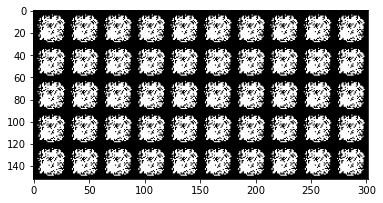

Iter: 06810/50000, Gen loss: 0.0000, Dis loss: 26.6504
Iter: 06820/50000, Gen loss: 0.0000, Dis loss: 28.5900
Iter: 06830/50000, Gen loss: 0.0000, Dis loss: 28.7886
Iter: 06840/50000, Gen loss: 0.0000, Dis loss: 27.3983
Iter: 06850/50000, Gen loss: 0.0000, Dis loss: 28.2669
Iter: 06860/50000, Gen loss: 0.0000, Dis loss: 27.7437
Iter: 06870/50000, Gen loss: 0.0000, Dis loss: 27.1900
Iter: 06880/50000, Gen loss: 0.0000, Dis loss: 27.6678
Iter: 06890/50000, Gen loss: 0.0000, Dis loss: 27.6870
Iter: 06900/50000, Gen loss: 0.0000, Dis loss: 28.3900
Iter: 06910/50000, Gen loss: 0.0000, Dis loss: 28.2995
Iter: 06920/50000, Gen loss: 0.0000, Dis loss: 28.1274
Iter: 06930/50000, Gen loss: 0.0000, Dis loss: 29.1187
Iter: 06940/50000, Gen loss: 0.0000, Dis loss: 28.8783
Iter: 06950/50000, Gen loss: 0.0000, Dis loss: 29.6170
Iter: 06960/50000, Gen loss: 0.0000, Dis loss: 29.1410
Iter: 06970/50000, Gen loss: 0.0000, Dis loss: 29.6110
Iter: 06980/50000, Gen loss: 0.0000, Dis loss: 29.5490
Iter: 0699

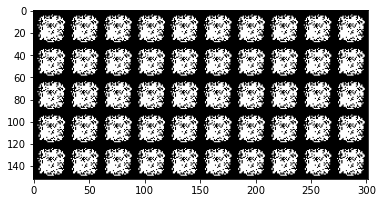

Iter: 07010/50000, Gen loss: 0.0000, Dis loss: 29.4774
Iter: 07020/50000, Gen loss: 0.0000, Dis loss: 27.8204
Iter: 07030/50000, Gen loss: 0.0000, Dis loss: 27.7546
Iter: 07040/50000, Gen loss: 0.0000, Dis loss: 28.0755
Iter: 07050/50000, Gen loss: 0.0000, Dis loss: 29.2629
Iter: 07060/50000, Gen loss: 0.0000, Dis loss: 28.9345
Iter: 07070/50000, Gen loss: 0.0000, Dis loss: 28.7435
Iter: 07080/50000, Gen loss: 0.0000, Dis loss: 29.1850
Iter: 07090/50000, Gen loss: 0.0000, Dis loss: 29.5252
Iter: 07100/50000, Gen loss: 0.0000, Dis loss: 29.6187
Iter: 07110/50000, Gen loss: 0.0000, Dis loss: 29.2316
Iter: 07120/50000, Gen loss: 0.0000, Dis loss: 29.3299
Iter: 07130/50000, Gen loss: 0.0000, Dis loss: 29.2254
Iter: 07140/50000, Gen loss: 0.0000, Dis loss: 29.6616
Iter: 07150/50000, Gen loss: 0.0000, Dis loss: 30.1875
Iter: 07160/50000, Gen loss: 0.0000, Dis loss: 29.7954
Iter: 07170/50000, Gen loss: 0.0000, Dis loss: 29.9082
Iter: 07180/50000, Gen loss: 0.0000, Dis loss: 30.4205
Iter: 0719

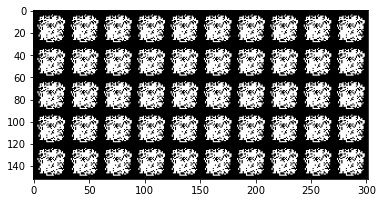

Iter: 07210/50000, Gen loss: 0.0000, Dis loss: 31.1254
Iter: 07220/50000, Gen loss: 0.0000, Dis loss: 30.2962
Iter: 07230/50000, Gen loss: 0.0000, Dis loss: 30.3581
Iter: 07240/50000, Gen loss: 0.0000, Dis loss: 29.0990
Iter: 07250/50000, Gen loss: 0.0000, Dis loss: 29.6976
Iter: 07260/50000, Gen loss: 0.0000, Dis loss: 29.0705
Iter: 07270/50000, Gen loss: 0.0000, Dis loss: 29.5953
Iter: 07280/50000, Gen loss: 0.0000, Dis loss: 29.0720
Iter: 07290/50000, Gen loss: 0.0000, Dis loss: 29.7482
Iter: 07300/50000, Gen loss: 0.0000, Dis loss: 29.2530
Iter: 07310/50000, Gen loss: 0.0000, Dis loss: 29.3627
Iter: 07320/50000, Gen loss: 0.0000, Dis loss: 29.8223
Iter: 07330/50000, Gen loss: 0.0000, Dis loss: 29.6439
Iter: 07340/50000, Gen loss: 0.0000, Dis loss: 28.6443
Iter: 07350/50000, Gen loss: 0.0000, Dis loss: 29.7101
Iter: 07360/50000, Gen loss: 0.0000, Dis loss: 29.4102
Iter: 07370/50000, Gen loss: 0.0000, Dis loss: 29.1472
Iter: 07380/50000, Gen loss: 0.0000, Dis loss: 29.9433
Iter: 0739

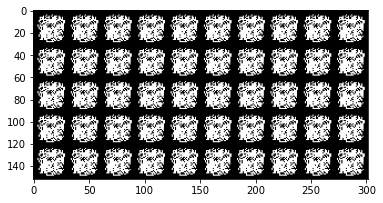

Iter: 07410/50000, Gen loss: 0.0000, Dis loss: 29.7283
Iter: 07420/50000, Gen loss: 0.0000, Dis loss: 30.0770
Iter: 07430/50000, Gen loss: 0.0000, Dis loss: 30.0639
Iter: 07440/50000, Gen loss: 0.0000, Dis loss: 30.7474
Iter: 07450/50000, Gen loss: 0.0000, Dis loss: 31.8481
Iter: 07460/50000, Gen loss: 0.0000, Dis loss: 31.6099
Iter: 07470/50000, Gen loss: 0.0000, Dis loss: 30.9672
Iter: 07480/50000, Gen loss: 0.0000, Dis loss: 31.8667
Iter: 07490/50000, Gen loss: 0.0000, Dis loss: 32.0984
Iter: 07500/50000, Gen loss: 0.0000, Dis loss: 32.3197
Iter: 07510/50000, Gen loss: 0.0000, Dis loss: 31.8906
Iter: 07520/50000, Gen loss: 0.0000, Dis loss: 32.2757
Iter: 07530/50000, Gen loss: 0.0000, Dis loss: 32.3971
Iter: 07540/50000, Gen loss: 0.0000, Dis loss: 32.6944
Iter: 07550/50000, Gen loss: 0.0000, Dis loss: 32.0046
Iter: 07560/50000, Gen loss: 0.0000, Dis loss: 31.9389
Iter: 07570/50000, Gen loss: 0.0000, Dis loss: 31.6743
Iter: 07580/50000, Gen loss: 0.0000, Dis loss: 30.9340
Iter: 0759

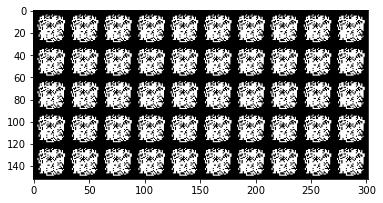

Iter: 07610/50000, Gen loss: 0.0000, Dis loss: 31.2995
Iter: 07620/50000, Gen loss: 0.0000, Dis loss: 31.0732
Iter: 07630/50000, Gen loss: 0.0000, Dis loss: 30.8107
Iter: 07640/50000, Gen loss: 0.0000, Dis loss: 31.3570
Iter: 07650/50000, Gen loss: 0.0000, Dis loss: 30.8463
Iter: 07660/50000, Gen loss: 0.0000, Dis loss: 31.4753
Iter: 07670/50000, Gen loss: 0.0000, Dis loss: 30.7199
Iter: 07680/50000, Gen loss: 0.0000, Dis loss: 31.4533
Iter: 07690/50000, Gen loss: 0.0000, Dis loss: 31.2548
Iter: 07700/50000, Gen loss: 0.0000, Dis loss: 32.6421
Iter: 07710/50000, Gen loss: 0.0000, Dis loss: 33.2361
Iter: 07720/50000, Gen loss: 0.0000, Dis loss: 32.5376
Iter: 07730/50000, Gen loss: 0.0000, Dis loss: 32.5106
Iter: 07740/50000, Gen loss: 0.0000, Dis loss: 32.6323
Iter: 07750/50000, Gen loss: 0.0000, Dis loss: 32.6647
Iter: 07760/50000, Gen loss: 0.0000, Dis loss: 33.3566
Iter: 07770/50000, Gen loss: 0.0000, Dis loss: 32.5075
Iter: 07780/50000, Gen loss: 0.0000, Dis loss: 32.0999
Iter: 0779

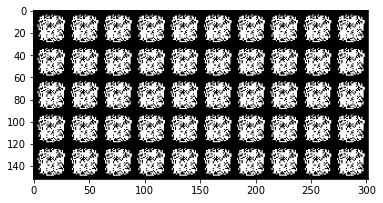

Iter: 07810/50000, Gen loss: 0.0000, Dis loss: 31.8197
Iter: 07820/50000, Gen loss: 0.0000, Dis loss: 32.3944
Iter: 07830/50000, Gen loss: 0.0000, Dis loss: 32.0026
Iter: 07840/50000, Gen loss: 0.0000, Dis loss: 33.1860
Iter: 07850/50000, Gen loss: 0.0000, Dis loss: 33.1502
Iter: 07860/50000, Gen loss: 0.0000, Dis loss: 33.0967
Iter: 07870/50000, Gen loss: 0.0000, Dis loss: 28.4646
Iter: 07880/50000, Gen loss: 0.0000, Dis loss: 29.3106
Iter: 07890/50000, Gen loss: 0.0000, Dis loss: 30.0070
Iter: 07900/50000, Gen loss: 0.0000, Dis loss: 29.8378
Iter: 07910/50000, Gen loss: 0.0000, Dis loss: 30.6926
Iter: 07920/50000, Gen loss: 0.0000, Dis loss: 30.8802
Iter: 07930/50000, Gen loss: 0.0000, Dis loss: 30.6546
Iter: 07940/50000, Gen loss: 0.0000, Dis loss: 30.7937
Iter: 07950/50000, Gen loss: 0.0000, Dis loss: 30.2539
Iter: 07960/50000, Gen loss: 0.0000, Dis loss: 31.8068
Iter: 07970/50000, Gen loss: 0.0000, Dis loss: 31.4222
Iter: 07980/50000, Gen loss: 0.0000, Dis loss: 31.2017
Iter: 0799

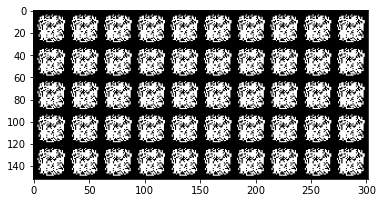

Iter: 08010/50000, Gen loss: 0.0000, Dis loss: 31.6875
Iter: 08020/50000, Gen loss: 0.0000, Dis loss: 30.8980
Iter: 08030/50000, Gen loss: 0.0000, Dis loss: 31.2905
Iter: 08040/50000, Gen loss: 0.0000, Dis loss: 31.4027
Iter: 08050/50000, Gen loss: 0.0000, Dis loss: 31.5930
Iter: 08060/50000, Gen loss: 0.0000, Dis loss: 31.0138
Iter: 08070/50000, Gen loss: 0.0000, Dis loss: 31.6232
Iter: 08080/50000, Gen loss: 0.0000, Dis loss: 30.8229
Iter: 08090/50000, Gen loss: 0.0000, Dis loss: 31.4494
Iter: 08100/50000, Gen loss: 0.0000, Dis loss: 30.9179
Iter: 08110/50000, Gen loss: 0.0000, Dis loss: 32.1449
Iter: 08120/50000, Gen loss: 0.0000, Dis loss: 32.2099
Iter: 08130/50000, Gen loss: 0.0000, Dis loss: 32.4278
Iter: 08140/50000, Gen loss: 0.0000, Dis loss: 32.2105
Iter: 08150/50000, Gen loss: 0.0000, Dis loss: 32.0461
Iter: 08160/50000, Gen loss: 0.0000, Dis loss: 32.4143
Iter: 08170/50000, Gen loss: 0.0000, Dis loss: 31.5758
Iter: 08180/50000, Gen loss: 0.0000, Dis loss: 32.0561
Iter: 0819

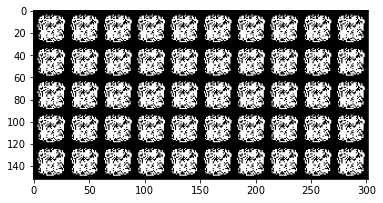

Iter: 08210/50000, Gen loss: 0.0000, Dis loss: 32.3243
Iter: 08220/50000, Gen loss: 0.0000, Dis loss: 32.9930
Iter: 08230/50000, Gen loss: 0.0000, Dis loss: 32.2621
Iter: 08240/50000, Gen loss: 0.0000, Dis loss: 31.6746
Iter: 08250/50000, Gen loss: 0.0000, Dis loss: 32.2409
Iter: 08260/50000, Gen loss: 0.0000, Dis loss: 32.0199
Iter: 08270/50000, Gen loss: 0.0000, Dis loss: 32.3473
Iter: 08280/50000, Gen loss: 0.0000, Dis loss: 32.5863
Iter: 08290/50000, Gen loss: 0.0000, Dis loss: 32.0061
Iter: 08300/50000, Gen loss: 0.0000, Dis loss: 32.9310
Iter: 08310/50000, Gen loss: 0.0000, Dis loss: 32.4235
Iter: 08320/50000, Gen loss: 0.0000, Dis loss: 33.0152
Iter: 08330/50000, Gen loss: 0.0000, Dis loss: 33.0061
Iter: 08340/50000, Gen loss: 0.0000, Dis loss: 33.2857
Iter: 08350/50000, Gen loss: 0.0000, Dis loss: 32.8240
Iter: 08360/50000, Gen loss: 0.0000, Dis loss: 33.1160
Iter: 08370/50000, Gen loss: 0.0000, Dis loss: 32.3821
Iter: 08380/50000, Gen loss: 0.0000, Dis loss: 32.9104
Iter: 0839

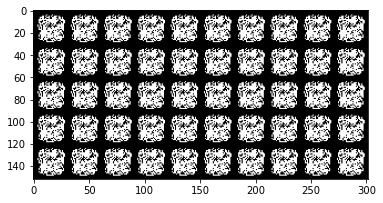

Iter: 08410/50000, Gen loss: 0.0000, Dis loss: 33.5425
Iter: 08420/50000, Gen loss: 0.0000, Dis loss: 32.3445
Iter: 08430/50000, Gen loss: 0.0000, Dis loss: 32.6318
Iter: 08440/50000, Gen loss: 0.0000, Dis loss: 32.8547
Iter: 08450/50000, Gen loss: 0.0000, Dis loss: 33.0393
Iter: 08460/50000, Gen loss: 0.0000, Dis loss: 33.3706
Iter: 08470/50000, Gen loss: 0.0000, Dis loss: 33.1904
Iter: 08480/50000, Gen loss: 0.0000, Dis loss: 33.6126
Iter: 08490/50000, Gen loss: 0.0000, Dis loss: 33.6747
Iter: 08500/50000, Gen loss: 0.0000, Dis loss: 33.6919
Iter: 08510/50000, Gen loss: 0.0000, Dis loss: 33.3571
Iter: 08520/50000, Gen loss: 0.0000, Dis loss: 33.3113
Iter: 08530/50000, Gen loss: 0.0000, Dis loss: 33.2811
Iter: 08540/50000, Gen loss: 0.0000, Dis loss: 33.3111
Iter: 08550/50000, Gen loss: 0.0000, Dis loss: 35.3302
Iter: 08560/50000, Gen loss: 0.0000, Dis loss: 35.3566
Iter: 08570/50000, Gen loss: 0.0000, Dis loss: 35.4385
Iter: 08580/50000, Gen loss: 0.0000, Dis loss: 35.6947
Iter: 0859

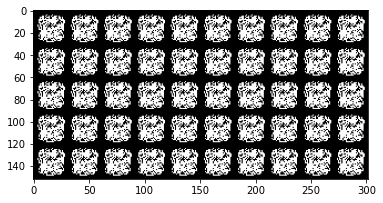

Iter: 08610/50000, Gen loss: 0.0000, Dis loss: 34.4463
Iter: 08620/50000, Gen loss: 0.0000, Dis loss: 34.9621
Iter: 08630/50000, Gen loss: 0.0000, Dis loss: 34.9022
Iter: 08640/50000, Gen loss: 0.0000, Dis loss: 34.3911
Iter: 08650/50000, Gen loss: 0.0000, Dis loss: 34.5331
Iter: 08660/50000, Gen loss: 0.0000, Dis loss: 34.2889
Iter: 08670/50000, Gen loss: 0.0000, Dis loss: 34.4920
Iter: 08680/50000, Gen loss: 0.0000, Dis loss: 34.5670
Iter: 08690/50000, Gen loss: 0.0000, Dis loss: 34.1081
Iter: 08700/50000, Gen loss: 0.0000, Dis loss: 33.8255
Iter: 08710/50000, Gen loss: 0.0000, Dis loss: 33.2183
Iter: 08720/50000, Gen loss: 0.0000, Dis loss: 32.6434
Iter: 08730/50000, Gen loss: 0.0000, Dis loss: 32.2497
Iter: 08740/50000, Gen loss: 0.0000, Dis loss: 32.1279
Iter: 08750/50000, Gen loss: 0.0000, Dis loss: 32.9251
Iter: 08760/50000, Gen loss: 0.0000, Dis loss: 32.6987
Iter: 08770/50000, Gen loss: 0.0000, Dis loss: 33.2484
Iter: 08780/50000, Gen loss: 0.0000, Dis loss: 33.3751
Iter: 0879

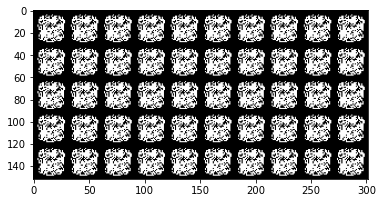

Iter: 08810/50000, Gen loss: 0.0000, Dis loss: 32.4985
Iter: 08820/50000, Gen loss: 0.0000, Dis loss: 32.4758
Iter: 08830/50000, Gen loss: 0.0000, Dis loss: 32.5405
Iter: 08840/50000, Gen loss: 0.0000, Dis loss: 32.8201
Iter: 08850/50000, Gen loss: 0.0000, Dis loss: 32.3372
Iter: 08860/50000, Gen loss: 0.0000, Dis loss: 32.5581
Iter: 08870/50000, Gen loss: 0.0000, Dis loss: 32.0035
Iter: 08880/50000, Gen loss: 0.0000, Dis loss: 32.6921
Iter: 08890/50000, Gen loss: 0.0000, Dis loss: 33.0598
Iter: 08900/50000, Gen loss: 0.0000, Dis loss: 33.1911
Iter: 08910/50000, Gen loss: 0.0000, Dis loss: 33.7210
Iter: 08920/50000, Gen loss: 0.0000, Dis loss: 33.4143
Iter: 08930/50000, Gen loss: 0.0000, Dis loss: 33.2454
Iter: 08940/50000, Gen loss: 0.0000, Dis loss: 32.6513
Iter: 08950/50000, Gen loss: 0.0000, Dis loss: 33.7107
Iter: 08960/50000, Gen loss: 0.0000, Dis loss: 33.8360
Iter: 08970/50000, Gen loss: 0.0000, Dis loss: 32.8196
Iter: 08980/50000, Gen loss: 0.0000, Dis loss: 33.0454
Iter: 0899

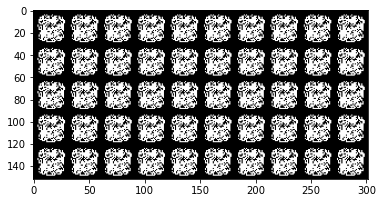

Iter: 09010/50000, Gen loss: 0.0000, Dis loss: 33.6512
Iter: 09020/50000, Gen loss: 0.0000, Dis loss: 33.7294
Iter: 09030/50000, Gen loss: 0.0000, Dis loss: 33.7529
Iter: 09040/50000, Gen loss: 0.0000, Dis loss: 33.4694
Iter: 09050/50000, Gen loss: 0.0000, Dis loss: 33.2866
Iter: 09060/50000, Gen loss: 0.0000, Dis loss: 33.0279
Iter: 09070/50000, Gen loss: 0.0000, Dis loss: 34.3716
Iter: 09080/50000, Gen loss: 0.0000, Dis loss: 34.2914
Iter: 09090/50000, Gen loss: 0.0000, Dis loss: 34.0905
Iter: 09100/50000, Gen loss: 0.0000, Dis loss: 33.8967
Iter: 09110/50000, Gen loss: 0.0000, Dis loss: 33.7180
Iter: 09120/50000, Gen loss: 0.0000, Dis loss: 34.1581
Iter: 09130/50000, Gen loss: 0.0000, Dis loss: 33.8857
Iter: 09140/50000, Gen loss: 0.0000, Dis loss: 33.5550
Iter: 09150/50000, Gen loss: 0.0000, Dis loss: 34.2035
Iter: 09160/50000, Gen loss: 0.0000, Dis loss: 33.2272
Iter: 09170/50000, Gen loss: 0.0000, Dis loss: 29.5681
Iter: 09180/50000, Gen loss: 0.0000, Dis loss: 31.1861
Iter: 0919

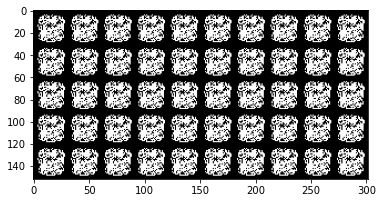

Iter: 09210/50000, Gen loss: 0.0000, Dis loss: 32.0792
Iter: 09220/50000, Gen loss: 0.0000, Dis loss: 32.6520
Iter: 09230/50000, Gen loss: 0.0000, Dis loss: 32.5296
Iter: 09240/50000, Gen loss: 0.0000, Dis loss: 32.1075
Iter: 09250/50000, Gen loss: 0.0000, Dis loss: 32.4489
Iter: 09260/50000, Gen loss: 0.0000, Dis loss: 31.8324
Iter: 09270/50000, Gen loss: 0.0000, Dis loss: 32.0153
Iter: 09280/50000, Gen loss: 0.0000, Dis loss: 32.5618
Iter: 09290/50000, Gen loss: 0.0000, Dis loss: 32.9016
Iter: 09300/50000, Gen loss: 0.0000, Dis loss: 32.5473
Iter: 09310/50000, Gen loss: 0.0000, Dis loss: 32.6070
Iter: 09320/50000, Gen loss: 0.0000, Dis loss: 33.3518
Iter: 09330/50000, Gen loss: 0.0000, Dis loss: 33.3277
Iter: 09340/50000, Gen loss: 0.0000, Dis loss: 33.3260
Iter: 09350/50000, Gen loss: 0.0000, Dis loss: 33.5510
Iter: 09360/50000, Gen loss: 0.0000, Dis loss: 32.8921
Iter: 09370/50000, Gen loss: 0.0000, Dis loss: 33.4320
Iter: 09380/50000, Gen loss: 0.0000, Dis loss: 33.7956
Iter: 0939

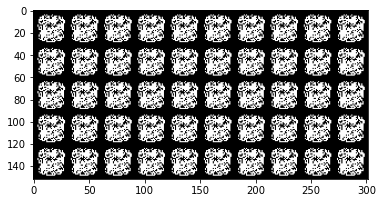

Iter: 09410/50000, Gen loss: 0.0000, Dis loss: 34.0659
Iter: 09420/50000, Gen loss: 0.0000, Dis loss: 33.0428
Iter: 09430/50000, Gen loss: 0.0000, Dis loss: 33.9357
Iter: 09440/50000, Gen loss: 0.0000, Dis loss: 33.5069
Iter: 09450/50000, Gen loss: 0.0000, Dis loss: 33.9773
Iter: 09460/50000, Gen loss: 0.0000, Dis loss: 33.8918
Iter: 09470/50000, Gen loss: 0.0000, Dis loss: 33.9000
Iter: 09480/50000, Gen loss: 0.0000, Dis loss: 34.0216
Iter: 09490/50000, Gen loss: 0.0000, Dis loss: 33.8136
Iter: 09500/50000, Gen loss: 0.0000, Dis loss: 33.5627
Iter: 09510/50000, Gen loss: 0.0000, Dis loss: 33.8742
Iter: 09520/50000, Gen loss: 0.0000, Dis loss: 34.4852
Iter: 09530/50000, Gen loss: 0.0000, Dis loss: 34.9993
Iter: 09540/50000, Gen loss: 0.0000, Dis loss: 33.7501
Iter: 09550/50000, Gen loss: 0.0000, Dis loss: 34.7928
Iter: 09560/50000, Gen loss: 0.0000, Dis loss: 34.3785
Iter: 09570/50000, Gen loss: 0.0000, Dis loss: 34.2836
Iter: 09580/50000, Gen loss: 0.0000, Dis loss: 34.3496
Iter: 0959

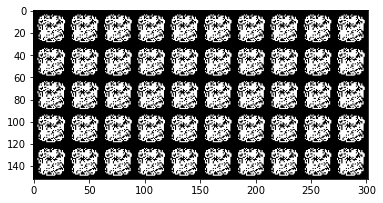

Iter: 09610/50000, Gen loss: 0.0000, Dis loss: 34.1430
Iter: 09620/50000, Gen loss: 0.0000, Dis loss: 34.3545
Iter: 09630/50000, Gen loss: 0.0000, Dis loss: 34.1220
Iter: 09640/50000, Gen loss: 0.0000, Dis loss: 34.7070
Iter: 09650/50000, Gen loss: 0.0000, Dis loss: 34.8282
Iter: 09660/50000, Gen loss: 0.0000, Dis loss: 34.6123
Iter: 09670/50000, Gen loss: 0.0000, Dis loss: 34.5826
Iter: 09680/50000, Gen loss: 0.0000, Dis loss: 35.1163
Iter: 09690/50000, Gen loss: 0.0000, Dis loss: 34.5117
Iter: 09700/50000, Gen loss: 0.0000, Dis loss: 33.7074
Iter: 09710/50000, Gen loss: 0.0000, Dis loss: 34.6233
Iter: 09720/50000, Gen loss: 0.0000, Dis loss: 34.3479
Iter: 09730/50000, Gen loss: 0.0000, Dis loss: 34.8420
Iter: 09740/50000, Gen loss: 0.0000, Dis loss: 34.5230
Iter: 09750/50000, Gen loss: 0.0000, Dis loss: 33.8966
Iter: 09760/50000, Gen loss: 0.0000, Dis loss: 34.7732
Iter: 09770/50000, Gen loss: 0.0000, Dis loss: 34.5684
Iter: 09780/50000, Gen loss: 0.0000, Dis loss: 34.9376
Iter: 0979

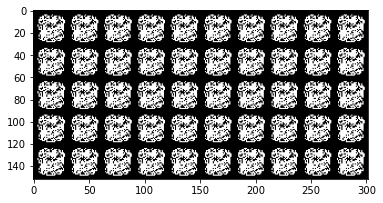

Iter: 09810/50000, Gen loss: 0.0000, Dis loss: 34.4611
Iter: 09820/50000, Gen loss: 0.0000, Dis loss: 34.2227
Iter: 09830/50000, Gen loss: 0.0000, Dis loss: 34.5416
Iter: 09840/50000, Gen loss: 0.0000, Dis loss: 34.3693
Iter: 09850/50000, Gen loss: 0.0000, Dis loss: 34.4892
Iter: 09860/50000, Gen loss: 0.0000, Dis loss: 33.8997
Iter: 09870/50000, Gen loss: 0.0000, Dis loss: 33.2756
Iter: 09880/50000, Gen loss: 0.0000, Dis loss: 34.5516
Iter: 09890/50000, Gen loss: 0.0000, Dis loss: 34.4363
Iter: 09900/50000, Gen loss: 0.0000, Dis loss: 35.0419
Iter: 09910/50000, Gen loss: 0.0000, Dis loss: 34.5345
Iter: 09920/50000, Gen loss: 0.0000, Dis loss: 34.1780
Iter: 09930/50000, Gen loss: 0.0000, Dis loss: 35.0525
Iter: 09940/50000, Gen loss: 0.0000, Dis loss: 34.2197
Iter: 09950/50000, Gen loss: 0.0000, Dis loss: 34.4684
Iter: 09960/50000, Gen loss: 0.0000, Dis loss: 34.6325
Iter: 09970/50000, Gen loss: 0.0000, Dis loss: 35.0873
Iter: 09980/50000, Gen loss: 0.0000, Dis loss: 34.9687
Iter: 0999

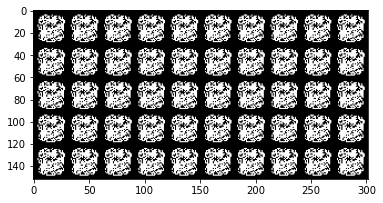

Iter: 10010/50000, Gen loss: 0.0000, Dis loss: 35.0592
Iter: 10020/50000, Gen loss: 0.0000, Dis loss: 34.5950
Iter: 10030/50000, Gen loss: 0.0000, Dis loss: 34.9640
Iter: 10040/50000, Gen loss: 0.0000, Dis loss: 34.6981
Iter: 10050/50000, Gen loss: 0.0000, Dis loss: 35.2143
Iter: 10060/50000, Gen loss: 0.0000, Dis loss: 35.4745
Iter: 10070/50000, Gen loss: 0.0000, Dis loss: 34.7431
Iter: 10080/50000, Gen loss: 0.0000, Dis loss: 34.5760
Iter: 10090/50000, Gen loss: 0.0000, Dis loss: 34.6939
Iter: 10100/50000, Gen loss: 0.0000, Dis loss: 34.5275
Iter: 10110/50000, Gen loss: 0.0000, Dis loss: 35.6257
Iter: 10120/50000, Gen loss: 0.0000, Dis loss: 34.8603
Iter: 10130/50000, Gen loss: 0.0000, Dis loss: 35.6521
Iter: 10140/50000, Gen loss: 0.0000, Dis loss: 34.1644
Iter: 10150/50000, Gen loss: 0.0000, Dis loss: 33.6157
Iter: 10160/50000, Gen loss: 0.0000, Dis loss: 34.4623
Iter: 10170/50000, Gen loss: 0.0000, Dis loss: 34.1648
Iter: 10180/50000, Gen loss: 0.0000, Dis loss: 34.1681
Iter: 1019

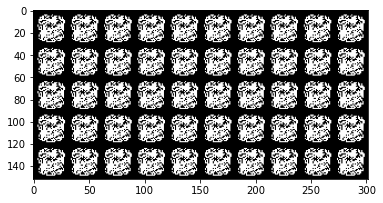

Iter: 10210/50000, Gen loss: 0.0000, Dis loss: 33.2851
Iter: 10220/50000, Gen loss: 0.0000, Dis loss: 33.2627
Iter: 10230/50000, Gen loss: 0.0000, Dis loss: 33.2965
Iter: 10240/50000, Gen loss: 0.0000, Dis loss: 33.1514
Iter: 10250/50000, Gen loss: 0.0000, Dis loss: 33.8323
Iter: 10260/50000, Gen loss: 0.0000, Dis loss: 33.5318
Iter: 10270/50000, Gen loss: 0.0000, Dis loss: 33.6467
Iter: 10280/50000, Gen loss: 0.0000, Dis loss: 34.1428
Iter: 10290/50000, Gen loss: 0.0000, Dis loss: 34.1967
Iter: 10300/50000, Gen loss: 0.0000, Dis loss: 34.4293
Iter: 10310/50000, Gen loss: 0.0000, Dis loss: 34.5446
Iter: 10320/50000, Gen loss: 0.0000, Dis loss: 34.6488
Iter: 10330/50000, Gen loss: 0.0000, Dis loss: 34.6276
Iter: 10340/50000, Gen loss: 0.0000, Dis loss: 34.8013
Iter: 10350/50000, Gen loss: 0.0000, Dis loss: 34.6381
Iter: 10360/50000, Gen loss: 0.0000, Dis loss: 35.1161
Iter: 10370/50000, Gen loss: 0.0000, Dis loss: 34.6863
Iter: 10380/50000, Gen loss: 0.0000, Dis loss: 34.9105
Iter: 1039

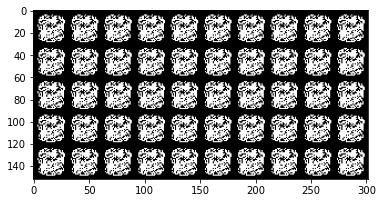

Iter: 10410/50000, Gen loss: 0.0000, Dis loss: 34.6495
Iter: 10420/50000, Gen loss: 0.0000, Dis loss: 34.7687
Iter: 10430/50000, Gen loss: 0.0000, Dis loss: 34.3207
Iter: 10440/50000, Gen loss: 0.0000, Dis loss: 35.0208
Iter: 10450/50000, Gen loss: 0.0000, Dis loss: 34.9590
Iter: 10460/50000, Gen loss: 0.0000, Dis loss: 34.8215
Iter: 10470/50000, Gen loss: 0.0000, Dis loss: 35.4240
Iter: 10480/50000, Gen loss: 0.0000, Dis loss: 34.6921
Iter: 10490/50000, Gen loss: 0.0000, Dis loss: 34.2116
Iter: 10500/50000, Gen loss: 0.0000, Dis loss: 34.6285
Iter: 10510/50000, Gen loss: 0.0000, Dis loss: 34.5924
Iter: 10520/50000, Gen loss: 0.0000, Dis loss: 34.7490
Iter: 10530/50000, Gen loss: 0.0000, Dis loss: 34.4750
Iter: 10540/50000, Gen loss: 0.0000, Dis loss: 35.1077
Iter: 10550/50000, Gen loss: 0.0000, Dis loss: 34.5073
Iter: 10560/50000, Gen loss: 0.0000, Dis loss: 34.2429
Iter: 10570/50000, Gen loss: 0.0000, Dis loss: 34.2713
Iter: 10580/50000, Gen loss: 0.0000, Dis loss: 35.1212
Iter: 1059

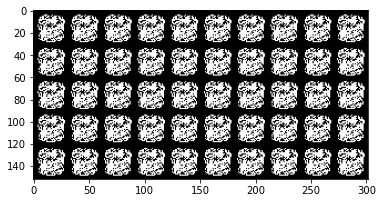

Iter: 10610/50000, Gen loss: 0.0000, Dis loss: 35.4487
Iter: 10620/50000, Gen loss: 0.0000, Dis loss: 35.0100
Iter: 10630/50000, Gen loss: 0.0000, Dis loss: 35.5427
Iter: 10640/50000, Gen loss: 0.0000, Dis loss: 35.4515
Iter: 10650/50000, Gen loss: 0.0000, Dis loss: 35.3172
Iter: 10660/50000, Gen loss: 0.0000, Dis loss: 35.0423
Iter: 10670/50000, Gen loss: 0.0000, Dis loss: 35.5348
Iter: 10680/50000, Gen loss: 0.0000, Dis loss: 35.6676
Iter: 10690/50000, Gen loss: 0.0000, Dis loss: 35.4883
Iter: 10700/50000, Gen loss: 0.0000, Dis loss: 34.8812
Iter: 10710/50000, Gen loss: 0.0000, Dis loss: 36.0151
Iter: 10720/50000, Gen loss: 0.0000, Dis loss: 34.5486
Iter: 10730/50000, Gen loss: 0.0000, Dis loss: 34.1707
Iter: 10740/50000, Gen loss: 0.0000, Dis loss: 35.0228
Iter: 10750/50000, Gen loss: 0.0000, Dis loss: 34.8119
Iter: 10760/50000, Gen loss: 0.0000, Dis loss: 34.9145
Iter: 10770/50000, Gen loss: 0.0000, Dis loss: 34.6354
Iter: 10780/50000, Gen loss: 0.0000, Dis loss: 35.2466
Iter: 1079

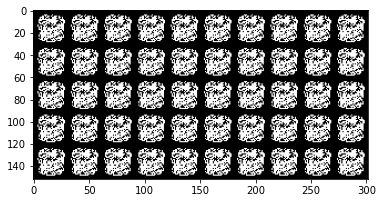

Iter: 10810/50000, Gen loss: 0.0000, Dis loss: 35.2680
Iter: 10820/50000, Gen loss: 0.0000, Dis loss: 35.2442
Iter: 10830/50000, Gen loss: 0.0000, Dis loss: 35.0199
Iter: 10840/50000, Gen loss: 0.0000, Dis loss: 35.5868
Iter: 10850/50000, Gen loss: 0.0000, Dis loss: 35.6795
Iter: 10860/50000, Gen loss: 0.0000, Dis loss: 35.3126
Iter: 10870/50000, Gen loss: 0.0000, Dis loss: 35.0909
Iter: 10880/50000, Gen loss: 0.0000, Dis loss: 35.6531
Iter: 10890/50000, Gen loss: 0.0000, Dis loss: 36.1627
Iter: 10900/50000, Gen loss: 0.0000, Dis loss: 35.6260
Iter: 10910/50000, Gen loss: 0.0000, Dis loss: 34.9639
Iter: 10920/50000, Gen loss: 0.0000, Dis loss: 35.9691
Iter: 10930/50000, Gen loss: 0.0000, Dis loss: 35.4218
Iter: 10940/50000, Gen loss: 0.0000, Dis loss: 35.2777
Iter: 10950/50000, Gen loss: 0.0000, Dis loss: 35.3579
Iter: 10960/50000, Gen loss: 0.0000, Dis loss: 35.5887
Iter: 10970/50000, Gen loss: 0.0000, Dis loss: 36.3263
Iter: 10980/50000, Gen loss: 0.0000, Dis loss: 33.9946
Iter: 1099

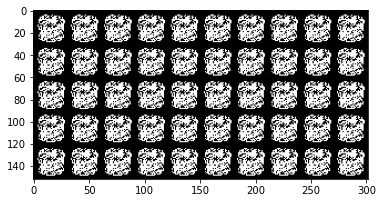

Iter: 11010/50000, Gen loss: 0.0000, Dis loss: 34.4683
Iter: 11020/50000, Gen loss: 0.0000, Dis loss: 34.3790
Iter: 11030/50000, Gen loss: 0.0000, Dis loss: 34.4266
Iter: 11040/50000, Gen loss: 0.0000, Dis loss: 34.7482
Iter: 11050/50000, Gen loss: 0.0000, Dis loss: 34.4811
Iter: 11060/50000, Gen loss: 0.0000, Dis loss: 35.5678
Iter: 11070/50000, Gen loss: 0.0000, Dis loss: 35.1721
Iter: 11080/50000, Gen loss: 0.0000, Dis loss: 34.4187
Iter: 11090/50000, Gen loss: 0.0000, Dis loss: 35.0969
Iter: 11100/50000, Gen loss: 0.0000, Dis loss: 34.4979
Iter: 11110/50000, Gen loss: 0.0000, Dis loss: 34.7705
Iter: 11120/50000, Gen loss: 0.0000, Dis loss: 34.7564
Iter: 11130/50000, Gen loss: 0.0000, Dis loss: 35.6782
Iter: 11140/50000, Gen loss: 0.0000, Dis loss: 35.0189
Iter: 11150/50000, Gen loss: 0.0000, Dis loss: 34.9272
Iter: 11160/50000, Gen loss: 0.0000, Dis loss: 35.6879
Iter: 11170/50000, Gen loss: 0.0000, Dis loss: 35.2128
Iter: 11180/50000, Gen loss: 0.0000, Dis loss: 35.1479
Iter: 1119

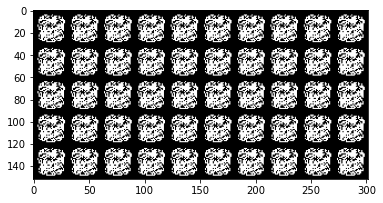

Iter: 11210/50000, Gen loss: 0.0000, Dis loss: 35.9987
Iter: 11220/50000, Gen loss: 0.0000, Dis loss: 35.6142
Iter: 11230/50000, Gen loss: 0.0000, Dis loss: 35.3636
Iter: 11240/50000, Gen loss: 0.0000, Dis loss: 35.1345
Iter: 11250/50000, Gen loss: 0.0000, Dis loss: 35.6220
Iter: 11260/50000, Gen loss: 0.0000, Dis loss: 35.4124
Iter: 11270/50000, Gen loss: 0.0000, Dis loss: 35.8744
Iter: 11280/50000, Gen loss: 0.0000, Dis loss: 35.3671
Iter: 11290/50000, Gen loss: 0.0000, Dis loss: 35.0989
Iter: 11300/50000, Gen loss: 0.0000, Dis loss: 35.2612
Iter: 11310/50000, Gen loss: 0.0000, Dis loss: 36.1769
Iter: 11320/50000, Gen loss: 0.0000, Dis loss: 35.2239
Iter: 11330/50000, Gen loss: 0.0000, Dis loss: 35.8206
Iter: 11340/50000, Gen loss: 0.0000, Dis loss: 35.5869
Iter: 11350/50000, Gen loss: 0.0000, Dis loss: 35.4392
Iter: 11360/50000, Gen loss: 0.0000, Dis loss: 35.5558
Iter: 11370/50000, Gen loss: 0.0000, Dis loss: 35.2736
Iter: 11380/50000, Gen loss: 0.0000, Dis loss: 35.7343
Iter: 1139

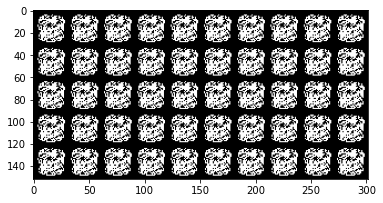

Iter: 11410/50000, Gen loss: 0.0000, Dis loss: 36.4725
Iter: 11420/50000, Gen loss: 0.0000, Dis loss: 35.8760
Iter: 11430/50000, Gen loss: 0.0000, Dis loss: 35.5481
Iter: 11440/50000, Gen loss: 0.0000, Dis loss: 36.7798
Iter: 11450/50000, Gen loss: 0.0000, Dis loss: 36.6294
Iter: 11460/50000, Gen loss: 0.0000, Dis loss: 36.6698
Iter: 11470/50000, Gen loss: 0.0000, Dis loss: 36.7831
Iter: 11480/50000, Gen loss: 0.0000, Dis loss: 36.4013
Iter: 11490/50000, Gen loss: 0.0000, Dis loss: 36.5452
Iter: 11500/50000, Gen loss: 0.0000, Dis loss: 36.3680
Iter: 11510/50000, Gen loss: 0.0000, Dis loss: 36.8138
Iter: 11520/50000, Gen loss: 0.0000, Dis loss: 36.3744
Iter: 11530/50000, Gen loss: 0.0000, Dis loss: 36.1830
Iter: 11540/50000, Gen loss: 0.0000, Dis loss: 36.0202
Iter: 11550/50000, Gen loss: 0.0000, Dis loss: 36.6924
Iter: 11560/50000, Gen loss: 0.0000, Dis loss: 35.9866
Iter: 11570/50000, Gen loss: 0.0000, Dis loss: 36.2225
Iter: 11580/50000, Gen loss: 0.0000, Dis loss: 36.7251
Iter: 1159

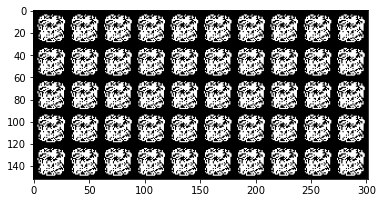

Iter: 11610/50000, Gen loss: 0.0000, Dis loss: 36.4979
Iter: 11620/50000, Gen loss: 0.0000, Dis loss: 36.5201
Iter: 11630/50000, Gen loss: 0.0000, Dis loss: 36.6001
Iter: 11640/50000, Gen loss: 0.0000, Dis loss: 37.2899
Iter: 11650/50000, Gen loss: 0.0000, Dis loss: 36.8817
Iter: 11660/50000, Gen loss: 0.0000, Dis loss: 36.7753
Iter: 11670/50000, Gen loss: 0.0000, Dis loss: 36.9198
Iter: 11680/50000, Gen loss: 0.0000, Dis loss: 36.6726
Iter: 11690/50000, Gen loss: 0.0000, Dis loss: 37.7462
Iter: 11700/50000, Gen loss: 0.0000, Dis loss: 38.0278
Iter: 11710/50000, Gen loss: 0.0000, Dis loss: 36.7719
Iter: 11720/50000, Gen loss: 0.0000, Dis loss: 37.6471
Iter: 11730/50000, Gen loss: 0.0000, Dis loss: 36.8925
Iter: 11740/50000, Gen loss: 0.0000, Dis loss: 36.9271
Iter: 11750/50000, Gen loss: 0.0000, Dis loss: 37.1202
Iter: 11760/50000, Gen loss: 0.0000, Dis loss: 36.4143
Iter: 11770/50000, Gen loss: 0.0000, Dis loss: 37.0555
Iter: 11780/50000, Gen loss: 0.0000, Dis loss: 37.5735
Iter: 1179

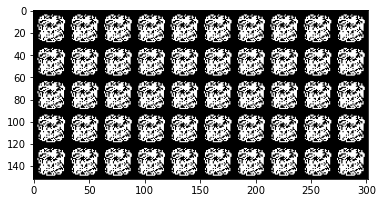

Iter: 11810/50000, Gen loss: 0.0000, Dis loss: 37.3060
Iter: 11820/50000, Gen loss: 0.0000, Dis loss: 37.2081
Iter: 11830/50000, Gen loss: 0.0000, Dis loss: 36.9088
Iter: 11840/50000, Gen loss: 0.0000, Dis loss: 36.9490
Iter: 11850/50000, Gen loss: 0.0000, Dis loss: 36.8282
Iter: 11860/50000, Gen loss: 0.0000, Dis loss: 37.4926
Iter: 11870/50000, Gen loss: 0.0000, Dis loss: 36.9578
Iter: 11880/50000, Gen loss: 0.0000, Dis loss: 37.0670
Iter: 11890/50000, Gen loss: 0.0000, Dis loss: 37.8344
Iter: 11900/50000, Gen loss: 0.0000, Dis loss: 37.0972
Iter: 11910/50000, Gen loss: 0.0000, Dis loss: 37.7106
Iter: 11920/50000, Gen loss: 0.0000, Dis loss: 37.5946
Iter: 11930/50000, Gen loss: 0.0000, Dis loss: 35.9294
Iter: 11940/50000, Gen loss: 0.0000, Dis loss: 36.1877
Iter: 11950/50000, Gen loss: 0.0000, Dis loss: 35.9497
Iter: 11960/50000, Gen loss: 0.0000, Dis loss: 35.0439
Iter: 11970/50000, Gen loss: 0.0000, Dis loss: 35.5336
Iter: 11980/50000, Gen loss: 0.0000, Dis loss: 35.7913
Iter: 1199

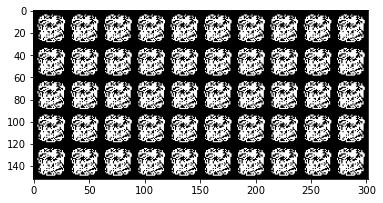

Iter: 12010/50000, Gen loss: 0.0000, Dis loss: 36.2232
Iter: 12020/50000, Gen loss: 0.0000, Dis loss: 36.1604
Iter: 12030/50000, Gen loss: 0.0000, Dis loss: 48.0879
Iter: 12040/50000, Gen loss: 0.0000, Dis loss: 48.4249
Iter: 12050/50000, Gen loss: 0.0000, Dis loss: 48.1553
Iter: 12060/50000, Gen loss: 0.0000, Dis loss: 47.8261
Iter: 12070/50000, Gen loss: 0.0000, Dis loss: 46.4374
Iter: 12080/50000, Gen loss: 0.0000, Dis loss: 47.0108
Iter: 12090/50000, Gen loss: 0.0000, Dis loss: 46.6458
Iter: 12100/50000, Gen loss: 0.0000, Dis loss: 47.4145
Iter: 12110/50000, Gen loss: 0.0000, Dis loss: 47.1848
Iter: 12120/50000, Gen loss: 0.0000, Dis loss: 47.5830
Iter: 12130/50000, Gen loss: 0.0000, Dis loss: 47.3957
Iter: 12140/50000, Gen loss: 0.0000, Dis loss: 46.4752
Iter: 12150/50000, Gen loss: 0.0000, Dis loss: 45.3504
Iter: 12160/50000, Gen loss: 0.0000, Dis loss: 46.4371
Iter: 12170/50000, Gen loss: 0.0000, Dis loss: 46.1030
Iter: 12180/50000, Gen loss: 0.0000, Dis loss: 45.1969
Iter: 1219

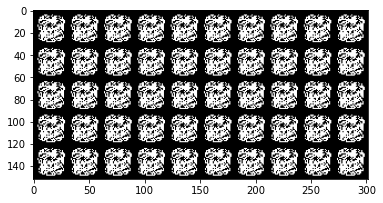

Iter: 12210/50000, Gen loss: 0.0000, Dis loss: 45.3150
Iter: 12220/50000, Gen loss: 0.0000, Dis loss: 44.8733
Iter: 12230/50000, Gen loss: 0.0000, Dis loss: 45.3567
Iter: 12240/50000, Gen loss: 0.0000, Dis loss: 45.0206
Iter: 12250/50000, Gen loss: 0.0000, Dis loss: 45.3644
Iter: 12260/50000, Gen loss: 0.0000, Dis loss: 45.4484
Iter: 12270/50000, Gen loss: 0.0000, Dis loss: 45.1092
Iter: 12280/50000, Gen loss: 0.0000, Dis loss: 46.2175
Iter: 12290/50000, Gen loss: 0.0000, Dis loss: 45.4587
Iter: 12300/50000, Gen loss: 0.0000, Dis loss: 44.8368
Iter: 12310/50000, Gen loss: 0.0000, Dis loss: 46.2882
Iter: 12320/50000, Gen loss: 0.0000, Dis loss: 45.8234
Iter: 12330/50000, Gen loss: 0.0000, Dis loss: 45.3503
Iter: 12340/50000, Gen loss: 0.0000, Dis loss: 45.1598
Iter: 12350/50000, Gen loss: 0.0000, Dis loss: 45.8621
Iter: 12360/50000, Gen loss: 0.0000, Dis loss: 46.2963
Iter: 12370/50000, Gen loss: 0.0000, Dis loss: 45.4755
Iter: 12380/50000, Gen loss: 0.0000, Dis loss: 45.4369
Iter: 1239

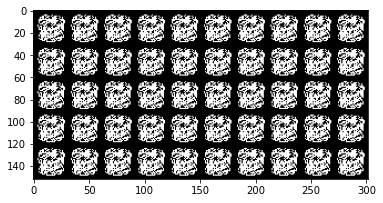

Iter: 12410/50000, Gen loss: 0.0000, Dis loss: 41.4128
Iter: 12420/50000, Gen loss: 0.0000, Dis loss: 41.4675
Iter: 12430/50000, Gen loss: 0.0000, Dis loss: 41.4243
Iter: 12440/50000, Gen loss: 0.0000, Dis loss: 41.7626
Iter: 12450/50000, Gen loss: 0.0000, Dis loss: 41.3796
Iter: 12460/50000, Gen loss: 0.0000, Dis loss: 40.9619
Iter: 12470/50000, Gen loss: 0.0000, Dis loss: 41.5687
Iter: 12480/50000, Gen loss: 0.0000, Dis loss: 42.2786
Iter: 12490/50000, Gen loss: 0.0000, Dis loss: 41.2425
Iter: 12500/50000, Gen loss: 0.0000, Dis loss: 42.1538
Iter: 12510/50000, Gen loss: 0.0000, Dis loss: 41.8145
Iter: 12520/50000, Gen loss: 0.0000, Dis loss: 42.5815
Iter: 12530/50000, Gen loss: 0.0000, Dis loss: 41.7261
Iter: 12540/50000, Gen loss: 0.0000, Dis loss: 41.4893
Iter: 12550/50000, Gen loss: 0.0000, Dis loss: 41.5819
Iter: 12560/50000, Gen loss: 0.0000, Dis loss: 41.2977
Iter: 12570/50000, Gen loss: 0.0000, Dis loss: 41.0679
Iter: 12580/50000, Gen loss: 0.0000, Dis loss: 41.4536
Iter: 1259

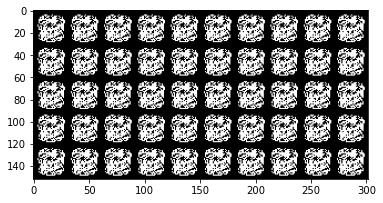

Iter: 12610/50000, Gen loss: 0.0000, Dis loss: 41.4499
Iter: 12620/50000, Gen loss: 0.0000, Dis loss: 41.8300
Iter: 12630/50000, Gen loss: 0.0000, Dis loss: 41.2024
Iter: 12640/50000, Gen loss: 0.0000, Dis loss: 41.2954
Iter: 12650/50000, Gen loss: 0.0000, Dis loss: 40.8756
Iter: 12660/50000, Gen loss: 0.0000, Dis loss: 41.7153
Iter: 12670/50000, Gen loss: 0.0000, Dis loss: 41.4566
Iter: 12680/50000, Gen loss: 0.0000, Dis loss: 41.4784
Iter: 12690/50000, Gen loss: 0.0000, Dis loss: 41.5389
Iter: 12700/50000, Gen loss: 0.0000, Dis loss: 42.0767
Iter: 12710/50000, Gen loss: 0.0000, Dis loss: 41.7431
Iter: 12720/50000, Gen loss: 0.0000, Dis loss: 41.9813
Iter: 12730/50000, Gen loss: 0.0000, Dis loss: 42.0757
Iter: 12740/50000, Gen loss: 0.0000, Dis loss: 41.5850
Iter: 12750/50000, Gen loss: 0.0000, Dis loss: 41.9415
Iter: 12760/50000, Gen loss: 0.0000, Dis loss: 42.2173
Iter: 12770/50000, Gen loss: 0.0000, Dis loss: 41.6340
Iter: 12780/50000, Gen loss: 0.0000, Dis loss: 41.8903
Iter: 1279

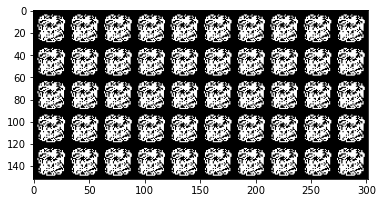

Iter: 12810/50000, Gen loss: 0.0000, Dis loss: 41.4984
Iter: 12820/50000, Gen loss: 0.0000, Dis loss: 41.8884
Iter: 12830/50000, Gen loss: 0.0000, Dis loss: 40.9116
Iter: 12840/50000, Gen loss: 0.0000, Dis loss: 42.3160
Iter: 12850/50000, Gen loss: 0.0000, Dis loss: 41.7895
Iter: 12860/50000, Gen loss: 0.0000, Dis loss: 41.8151
Iter: 12870/50000, Gen loss: 0.0000, Dis loss: 41.0576
Iter: 12880/50000, Gen loss: 0.0000, Dis loss: 40.8684
Iter: 12890/50000, Gen loss: 0.0000, Dis loss: 41.6516
Iter: 12900/50000, Gen loss: 0.0000, Dis loss: 41.3480
Iter: 12910/50000, Gen loss: 0.0000, Dis loss: 42.1224
Iter: 12920/50000, Gen loss: 0.0000, Dis loss: 41.3409
Iter: 12930/50000, Gen loss: 0.0000, Dis loss: 41.6208
Iter: 12940/50000, Gen loss: 0.0000, Dis loss: 41.0918
Iter: 12950/50000, Gen loss: 0.0000, Dis loss: 41.5276
Iter: 12960/50000, Gen loss: 0.0000, Dis loss: 41.6638
Iter: 12970/50000, Gen loss: 0.0000, Dis loss: 41.5482
Iter: 12980/50000, Gen loss: 0.0000, Dis loss: 41.5968
Iter: 1299

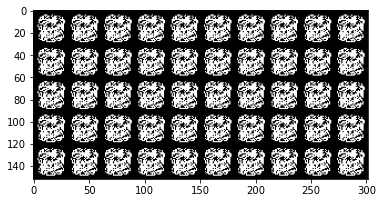

Iter: 13010/50000, Gen loss: 0.0000, Dis loss: 41.7511
Iter: 13020/50000, Gen loss: 0.0000, Dis loss: 41.3355
Iter: 13030/50000, Gen loss: 0.0000, Dis loss: 41.9822
Iter: 13040/50000, Gen loss: 0.0000, Dis loss: 41.1240
Iter: 13050/50000, Gen loss: 0.0000, Dis loss: 41.7381
Iter: 13060/50000, Gen loss: 0.0000, Dis loss: 41.7026
Iter: 13070/50000, Gen loss: 0.0000, Dis loss: 41.8403
Iter: 13080/50000, Gen loss: 0.0000, Dis loss: 41.3875
Iter: 13090/50000, Gen loss: 0.0000, Dis loss: 41.6483
Iter: 13100/50000, Gen loss: 0.0000, Dis loss: 41.5189
Iter: 13110/50000, Gen loss: 0.0000, Dis loss: 41.5899
Iter: 13120/50000, Gen loss: 0.0000, Dis loss: 40.9501
Iter: 13130/50000, Gen loss: 0.0000, Dis loss: 41.3176
Iter: 13140/50000, Gen loss: 0.0000, Dis loss: 40.6234
Iter: 13150/50000, Gen loss: 0.0000, Dis loss: 41.3064
Iter: 13160/50000, Gen loss: 0.0000, Dis loss: 40.9971
Iter: 13170/50000, Gen loss: 0.0000, Dis loss: 40.6843
Iter: 13180/50000, Gen loss: 0.0000, Dis loss: 41.6413
Iter: 1319

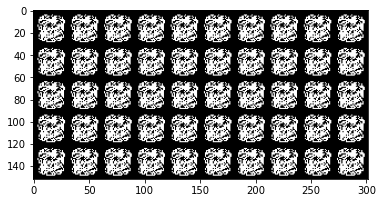

Iter: 13210/50000, Gen loss: 0.0000, Dis loss: 41.2923
Iter: 13220/50000, Gen loss: 0.0000, Dis loss: 40.5196
Iter: 13230/50000, Gen loss: 0.0000, Dis loss: 41.4668
Iter: 13240/50000, Gen loss: 0.0000, Dis loss: 41.1952
Iter: 13250/50000, Gen loss: 0.0000, Dis loss: 42.0711
Iter: 13260/50000, Gen loss: 0.0000, Dis loss: 41.9344
Iter: 13270/50000, Gen loss: 0.0000, Dis loss: 42.0725
Iter: 13280/50000, Gen loss: 0.0000, Dis loss: 41.1738
Iter: 13290/50000, Gen loss: 0.0000, Dis loss: 41.7080
Iter: 13300/50000, Gen loss: 0.0000, Dis loss: 40.9307
Iter: 13310/50000, Gen loss: 0.0000, Dis loss: 41.0051
Iter: 13320/50000, Gen loss: 0.0000, Dis loss: 41.6436
Iter: 13330/50000, Gen loss: 0.0000, Dis loss: 41.2105
Iter: 13340/50000, Gen loss: 0.0000, Dis loss: 41.2616
Iter: 13350/50000, Gen loss: 0.0000, Dis loss: 41.6582
Iter: 13360/50000, Gen loss: 0.0000, Dis loss: 40.7519
Iter: 13370/50000, Gen loss: 0.0000, Dis loss: 41.0879
Iter: 13380/50000, Gen loss: 0.0000, Dis loss: 40.8922
Iter: 1339

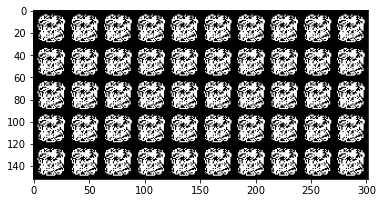

Iter: 13410/50000, Gen loss: 0.0000, Dis loss: 41.4340
Iter: 13420/50000, Gen loss: 0.0000, Dis loss: 41.2857
Iter: 13430/50000, Gen loss: 0.0000, Dis loss: 41.6912
Iter: 13440/50000, Gen loss: 0.0000, Dis loss: 41.2971
Iter: 13450/50000, Gen loss: 0.0000, Dis loss: 41.4096
Iter: 13460/50000, Gen loss: 0.0000, Dis loss: 40.4281
Iter: 13470/50000, Gen loss: 0.0000, Dis loss: 41.2878
Iter: 13480/50000, Gen loss: 0.0000, Dis loss: 41.3650
Iter: 13490/50000, Gen loss: 0.0000, Dis loss: 41.5755
Iter: 13500/50000, Gen loss: 0.0000, Dis loss: 42.1805
Iter: 13510/50000, Gen loss: 0.0000, Dis loss: 41.5903
Iter: 13520/50000, Gen loss: 0.0000, Dis loss: 41.7466
Iter: 13530/50000, Gen loss: 0.0000, Dis loss: 41.1476
Iter: 13540/50000, Gen loss: 0.0000, Dis loss: 41.2379
Iter: 13550/50000, Gen loss: 0.0000, Dis loss: 41.5046
Iter: 13560/50000, Gen loss: 0.0000, Dis loss: 41.9240
Iter: 13570/50000, Gen loss: 0.0000, Dis loss: 41.6771
Iter: 13580/50000, Gen loss: 0.0000, Dis loss: 41.1361
Iter: 1359

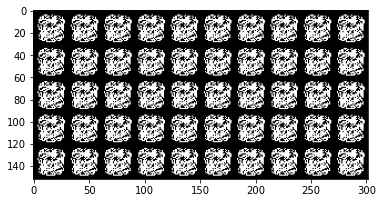

Iter: 13610/50000, Gen loss: 0.0000, Dis loss: 41.4959
Iter: 13620/50000, Gen loss: 0.0000, Dis loss: 40.9002
Iter: 13630/50000, Gen loss: 0.0000, Dis loss: 41.5231
Iter: 13640/50000, Gen loss: 0.0000, Dis loss: 41.6505
Iter: 13650/50000, Gen loss: 0.0000, Dis loss: 41.3816
Iter: 13660/50000, Gen loss: 0.0000, Dis loss: 41.2017
Iter: 13670/50000, Gen loss: 0.0000, Dis loss: 41.3074
Iter: 13680/50000, Gen loss: 0.0000, Dis loss: 41.2810
Iter: 13690/50000, Gen loss: 0.0000, Dis loss: 40.9974
Iter: 13700/50000, Gen loss: 0.0000, Dis loss: 40.8755
Iter: 13710/50000, Gen loss: 0.0000, Dis loss: 40.0453
Iter: 13720/50000, Gen loss: 0.0000, Dis loss: 41.3452
Iter: 13730/50000, Gen loss: 0.0000, Dis loss: 41.8156
Iter: 13740/50000, Gen loss: 0.0000, Dis loss: 41.2664
Iter: 13750/50000, Gen loss: 0.0000, Dis loss: 41.5321
Iter: 13760/50000, Gen loss: 0.0000, Dis loss: 40.9430
Iter: 13770/50000, Gen loss: 0.0000, Dis loss: 41.4914
Iter: 13780/50000, Gen loss: 0.0000, Dis loss: 41.0450
Iter: 1379

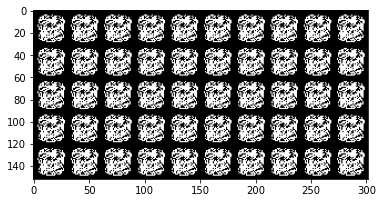

Iter: 13810/50000, Gen loss: 0.0000, Dis loss: 41.5337
Iter: 13820/50000, Gen loss: 0.0000, Dis loss: 41.2972
Iter: 13830/50000, Gen loss: 0.0000, Dis loss: 41.0890
Iter: 13840/50000, Gen loss: 0.0000, Dis loss: 41.2209
Iter: 13850/50000, Gen loss: 0.0000, Dis loss: 41.2665
Iter: 13860/50000, Gen loss: 0.0000, Dis loss: 41.3626
Iter: 13870/50000, Gen loss: 0.0000, Dis loss: 41.0335
Iter: 13880/50000, Gen loss: 0.0000, Dis loss: 40.8825
Iter: 13890/50000, Gen loss: 0.0000, Dis loss: 41.6170
Iter: 13900/50000, Gen loss: 0.0000, Dis loss: 41.5997
Iter: 13910/50000, Gen loss: 0.0000, Dis loss: 41.5574
Iter: 13920/50000, Gen loss: 0.0000, Dis loss: 41.9886
Iter: 13930/50000, Gen loss: 0.0000, Dis loss: 42.3516
Iter: 13940/50000, Gen loss: 0.0000, Dis loss: 41.9147
Iter: 13950/50000, Gen loss: 0.0000, Dis loss: 41.9017
Iter: 13960/50000, Gen loss: 0.0000, Dis loss: 41.2379
Iter: 13970/50000, Gen loss: 0.0000, Dis loss: 40.7790
Iter: 13980/50000, Gen loss: 0.0000, Dis loss: 41.3589
Iter: 1399

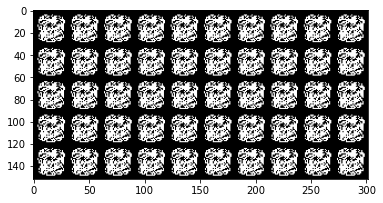

Iter: 14010/50000, Gen loss: 0.0000, Dis loss: 41.9760
Iter: 14020/50000, Gen loss: 0.0000, Dis loss: 41.3333
Iter: 14030/50000, Gen loss: 0.0000, Dis loss: 41.3087
Iter: 14040/50000, Gen loss: 0.0000, Dis loss: 40.9236
Iter: 14050/50000, Gen loss: 0.0000, Dis loss: 41.6390
Iter: 14060/50000, Gen loss: 0.0000, Dis loss: 41.2949
Iter: 14070/50000, Gen loss: 0.0000, Dis loss: 41.1439
Iter: 14080/50000, Gen loss: 0.0000, Dis loss: 41.6325
Iter: 14090/50000, Gen loss: 0.0000, Dis loss: 41.9406
Iter: 14100/50000, Gen loss: 0.0000, Dis loss: 41.1696
Iter: 14110/50000, Gen loss: 0.0000, Dis loss: 41.1331
Iter: 14120/50000, Gen loss: 0.0000, Dis loss: 41.2758
Iter: 14130/50000, Gen loss: 0.0000, Dis loss: 41.9934
Iter: 14140/50000, Gen loss: 0.0000, Dis loss: 41.4120
Iter: 14150/50000, Gen loss: 0.0000, Dis loss: 41.0552
Iter: 14160/50000, Gen loss: 0.0000, Dis loss: 42.2637
Iter: 14170/50000, Gen loss: 0.0000, Dis loss: 42.1799
Iter: 14180/50000, Gen loss: 0.0000, Dis loss: 41.6120
Iter: 1419

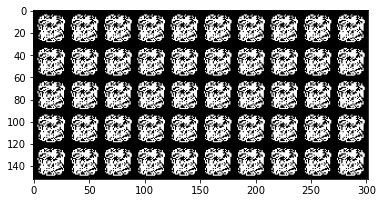

Iter: 14210/50000, Gen loss: 0.0000, Dis loss: 41.5089
Iter: 14220/50000, Gen loss: 0.0000, Dis loss: 41.5273
Iter: 14230/50000, Gen loss: 0.0000, Dis loss: 42.8196
Iter: 14240/50000, Gen loss: 0.0000, Dis loss: 41.0067
Iter: 14250/50000, Gen loss: 0.0000, Dis loss: 41.7231
Iter: 14260/50000, Gen loss: 0.0000, Dis loss: 41.0063
Iter: 14270/50000, Gen loss: 0.0000, Dis loss: 41.3908
Iter: 14280/50000, Gen loss: 0.0000, Dis loss: 41.3219
Iter: 14290/50000, Gen loss: 0.0000, Dis loss: 41.3197
Iter: 14300/50000, Gen loss: 0.0000, Dis loss: 40.5873
Iter: 14310/50000, Gen loss: 0.0000, Dis loss: 41.4758
Iter: 14320/50000, Gen loss: 0.0000, Dis loss: 41.4712
Iter: 14330/50000, Gen loss: 0.0000, Dis loss: 41.1366
Iter: 14340/50000, Gen loss: 0.0000, Dis loss: 41.0566
Iter: 14350/50000, Gen loss: 0.0000, Dis loss: 41.5049
Iter: 14360/50000, Gen loss: 0.0000, Dis loss: 41.5736
Iter: 14370/50000, Gen loss: 0.0000, Dis loss: 41.3592
Iter: 14380/50000, Gen loss: 0.0000, Dis loss: 41.5566
Iter: 1439

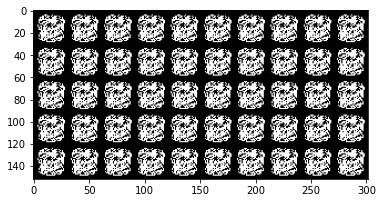

Iter: 14410/50000, Gen loss: 0.0000, Dis loss: 41.1960
Iter: 14420/50000, Gen loss: 0.0000, Dis loss: 40.7148
Iter: 14430/50000, Gen loss: 0.0000, Dis loss: 41.7640
Iter: 14440/50000, Gen loss: 0.0000, Dis loss: 41.2318
Iter: 14450/50000, Gen loss: 0.0000, Dis loss: 41.9826
Iter: 14460/50000, Gen loss: 0.0000, Dis loss: 41.2026
Iter: 14470/50000, Gen loss: 0.0000, Dis loss: 42.1660
Iter: 14480/50000, Gen loss: 0.0000, Dis loss: 41.7344
Iter: 14490/50000, Gen loss: 0.0000, Dis loss: 41.8836
Iter: 14500/50000, Gen loss: 0.0000, Dis loss: 41.4713
Iter: 14510/50000, Gen loss: 0.0000, Dis loss: 41.1609
Iter: 14520/50000, Gen loss: 0.0000, Dis loss: 41.4515
Iter: 14530/50000, Gen loss: 0.0000, Dis loss: 41.3252
Iter: 14540/50000, Gen loss: 0.0000, Dis loss: 41.8368
Iter: 14550/50000, Gen loss: 0.0000, Dis loss: 41.8793
Iter: 14560/50000, Gen loss: 0.0000, Dis loss: 40.7846
Iter: 14570/50000, Gen loss: 0.0000, Dis loss: 41.9331
Iter: 14580/50000, Gen loss: 0.0000, Dis loss: 41.2061
Iter: 1459

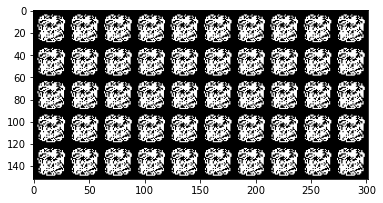

Iter: 14610/50000, Gen loss: 0.0000, Dis loss: 41.7638
Iter: 14620/50000, Gen loss: 0.0000, Dis loss: 41.6045
Iter: 14630/50000, Gen loss: 0.0000, Dis loss: 41.7138
Iter: 14640/50000, Gen loss: 0.0000, Dis loss: 41.3011
Iter: 14650/50000, Gen loss: 0.0000, Dis loss: 41.0847
Iter: 14660/50000, Gen loss: 0.0000, Dis loss: 41.7157
Iter: 14670/50000, Gen loss: 0.0000, Dis loss: 41.7658
Iter: 14680/50000, Gen loss: 0.0000, Dis loss: 41.4960
Iter: 14690/50000, Gen loss: 0.0000, Dis loss: 41.5345
Iter: 14700/50000, Gen loss: 0.0000, Dis loss: 41.4702
Iter: 14710/50000, Gen loss: 0.0000, Dis loss: 42.1754
Iter: 14720/50000, Gen loss: 0.0000, Dis loss: 42.0380
Iter: 14730/50000, Gen loss: 0.0000, Dis loss: 41.0541
Iter: 14740/50000, Gen loss: 0.0000, Dis loss: 41.8914
Iter: 14750/50000, Gen loss: 0.0000, Dis loss: 41.5187
Iter: 14760/50000, Gen loss: 0.0000, Dis loss: 41.0957
Iter: 14770/50000, Gen loss: 0.0000, Dis loss: 40.8672
Iter: 14780/50000, Gen loss: 0.0000, Dis loss: 41.5446
Iter: 1479

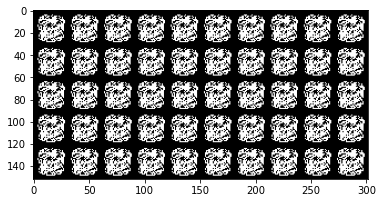

Iter: 14810/50000, Gen loss: 0.0000, Dis loss: 41.1622
Iter: 14820/50000, Gen loss: 0.0000, Dis loss: 41.6432
Iter: 14830/50000, Gen loss: 0.0000, Dis loss: 41.7319
Iter: 14840/50000, Gen loss: 0.0000, Dis loss: 40.9800
Iter: 14850/50000, Gen loss: 0.0000, Dis loss: 41.7752
Iter: 14860/50000, Gen loss: 0.0000, Dis loss: 41.5131
Iter: 14870/50000, Gen loss: 0.0000, Dis loss: 41.5026
Iter: 14880/50000, Gen loss: 0.0000, Dis loss: 42.0170
Iter: 14890/50000, Gen loss: 0.0000, Dis loss: 41.6887
Iter: 14900/50000, Gen loss: 0.0000, Dis loss: 40.8697
Iter: 14910/50000, Gen loss: 0.0000, Dis loss: 41.5645
Iter: 14920/50000, Gen loss: 0.0000, Dis loss: 41.8433
Iter: 14930/50000, Gen loss: 0.0000, Dis loss: 40.7912
Iter: 14940/50000, Gen loss: 0.0000, Dis loss: 41.7957
Iter: 14950/50000, Gen loss: 0.0000, Dis loss: 41.6861
Iter: 14960/50000, Gen loss: 0.0000, Dis loss: 41.4197
Iter: 14970/50000, Gen loss: 0.0000, Dis loss: 41.2433
Iter: 14980/50000, Gen loss: 0.0000, Dis loss: 41.4338
Iter: 1499

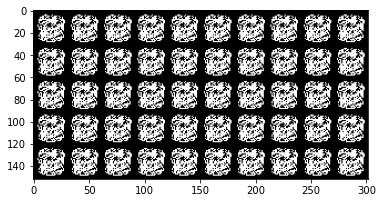

Iter: 15010/50000, Gen loss: 0.0000, Dis loss: 41.2933
Iter: 15020/50000, Gen loss: 0.0000, Dis loss: 41.4850
Iter: 15030/50000, Gen loss: 0.0000, Dis loss: 41.4223
Iter: 15040/50000, Gen loss: 0.0000, Dis loss: 41.7383
Iter: 15050/50000, Gen loss: 0.0000, Dis loss: 41.8033
Iter: 15060/50000, Gen loss: 0.0000, Dis loss: 41.8870
Iter: 15070/50000, Gen loss: 0.0000, Dis loss: 42.2499
Iter: 15080/50000, Gen loss: 0.0000, Dis loss: 41.7422
Iter: 15090/50000, Gen loss: 0.0000, Dis loss: 41.4226
Iter: 15100/50000, Gen loss: 0.0000, Dis loss: 41.6793
Iter: 15110/50000, Gen loss: 0.0000, Dis loss: 41.7288
Iter: 15120/50000, Gen loss: 0.0000, Dis loss: 40.9766
Iter: 15130/50000, Gen loss: 0.0000, Dis loss: 41.4129
Iter: 15140/50000, Gen loss: 0.0000, Dis loss: 41.3560
Iter: 15150/50000, Gen loss: 0.0000, Dis loss: 41.1297
Iter: 15160/50000, Gen loss: 0.0000, Dis loss: 41.0676
Iter: 15170/50000, Gen loss: 0.0000, Dis loss: 41.1532
Iter: 15180/50000, Gen loss: 0.0000, Dis loss: 41.2663
Iter: 1519

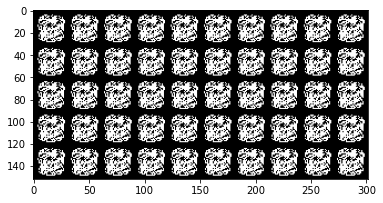

Iter: 15210/50000, Gen loss: 0.0000, Dis loss: 41.7661
Iter: 15220/50000, Gen loss: 0.0000, Dis loss: 41.2215
Iter: 15230/50000, Gen loss: 0.0000, Dis loss: 41.1881
Iter: 15240/50000, Gen loss: 0.0000, Dis loss: 41.7850
Iter: 15250/50000, Gen loss: 0.0000, Dis loss: 41.2973


KeyboardInterrupt: 

In [33]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_iter = iter(dataloader)

netG = Generator(latent_dim, img_dim).to(device)
# netD = Discriminator(img_dim).to(device)
netD = Discriminator(img_dim).to(device)
optimG = torch.optim.Adam(netG.parameters(), learning_rate)
optimD = torch.optim.Adam(netD.parameters(), learning_rate)

real_labels = torch.ones(batch_size).to(device)
fake_labels = torch.zeros(batch_size).to(device)

criterion = nn.BCELoss()

for it in range(total_iter):
    
    # train Discriminator
    for _ in range(num_D_updates_per_G_update):
        try:
            real_imgs, _ = next(dataloader_iter)
        except:
            dataloader_iter = iter(dataloader)
            real_imgs, _ = next(dataloader_iter)

        # real_imgs = real_imgs.to(device)
        real_imgs = real_imgs.view((-1, img_dim)).to(device)
        z = torch.randn((batch_size, latent_dim)).to(device)
        fake_imgs = netG(z).detach()
        real_probs = netD(real_imgs).squeeze()
        fake_probs = netD(fake_imgs).squeeze()

        ################ ToDo ################
        
        D_loss = 

        optimD.zero_grad()
        D_loss.backward()
        optimD.step()
      
    # train the Generator
    z = torch.randn((batch_size, latent_dim)).to(device)
    fake_imgs = netG(z)
        
    fake_probs = netD(fake_imgs)

    ################ ToDo ################
    y = torch.ones(batch_size, 1).to(device)
    G_loss = criterion(fake_probs, y)

    optimG.zero_grad()
    G_loss.backward()
    optimG.step()
    
    if (it+1) % log_freq == 0:
        print("Iter: %05d/%d, Gen loss: %.4f, Dis loss: %.4f"%(it+1, total_iter,
                                                              D_loss.data.item(),
                                                              G_loss.data.item()))
    if (it+1) % viz_freq == 0:
        z = torch.randn((gen_num_samples, latent_dim)).to(device)
        with torch.no_grad():
            gen_imgs = netG(z).view((50, 1, 28, 28))
        gen_imgs = make_grid(gen_imgs, nrow=10).permute(1, 2, 0).cpu().detach().numpy()
        plt.imshow(gen_imgs)
        plt.show()